In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import math
import plotly.express as px
import statsmodels.api as sm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')
original = pd.read_csv('../input/crab-age-prediction/CrabAgePrediction.csv')

test_ids = test['id']
test.drop(columns='id', inplace=True)

/kaggle/input/crab-age-prediction/CrabAgePrediction.csv
/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


This notebook builds a regression model for the **Playground Series Season 3 Episode 16** competition. The dataset for this competition (both train and test) was generated from a deep learning model trained on the **Crab Age Prediction** dataset. For this specific episode, the models are evaluated by Mean Absolute Error (MAE).

My approach for the problem was to first understand how the original data behaves, so I can use the insights to predict the synthetic generated data.

In [2]:
# Pallete
# Props to @sergiosaharovskiy

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

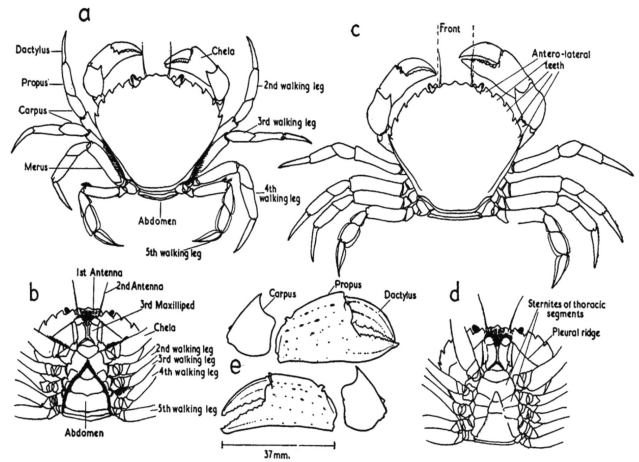

Anatomy and morphological criteria of *Carcinus maenas*, published by Crothers (1967). 
* a, b: **Female**, dorsal, and ventral view; 
* c, d: **Male**, dorsal, and ventral view;
* e: chelae of the male.

In [3]:
original.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
        .background_gradient(subset=['std'], cmap='Blues')\
        .background_gradient(subset=['50%'], cmap='BuGn')

In [4]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [5]:
def drop_missing_rows(df):
    if df.isnull().any().any():
        print("Missing values found in the dataframe.")
        df = df.dropna(axis=0)
        dropped_rows = len(df) - len(df.dropna())
        print(f"Dropped {dropped_rows} rows.")
    else:
        print("No missing values found in the dataframe.")

    return df

df = drop_missing_rows(df)
original = drop_missing_rows(original)
test = drop_missing_rows(test)

No missing values found in the dataframe.
No missing values found in the dataframe.
No missing values found in the dataframe.


In [6]:
def drop_duplicate_rows(df):
    if df.duplicated().any():
        print("Duplicate rows found in the dataframe.")
        df = df.drop_duplicates()
        dropped_rows = len(df) - len(df.drop_duplicates())
        print(f"Dropped {dropped_rows} rows.")
    else:
        print("No duplicate rows found in the dataframe.")

    return df

df = drop_duplicate_rows(df)
original = drop_duplicate_rows(original)
test = drop_duplicate_rows(test)

No duplicate rows found in the dataframe.
No duplicate rows found in the dataframe.
No duplicate rows found in the dataframe.


## Original Data

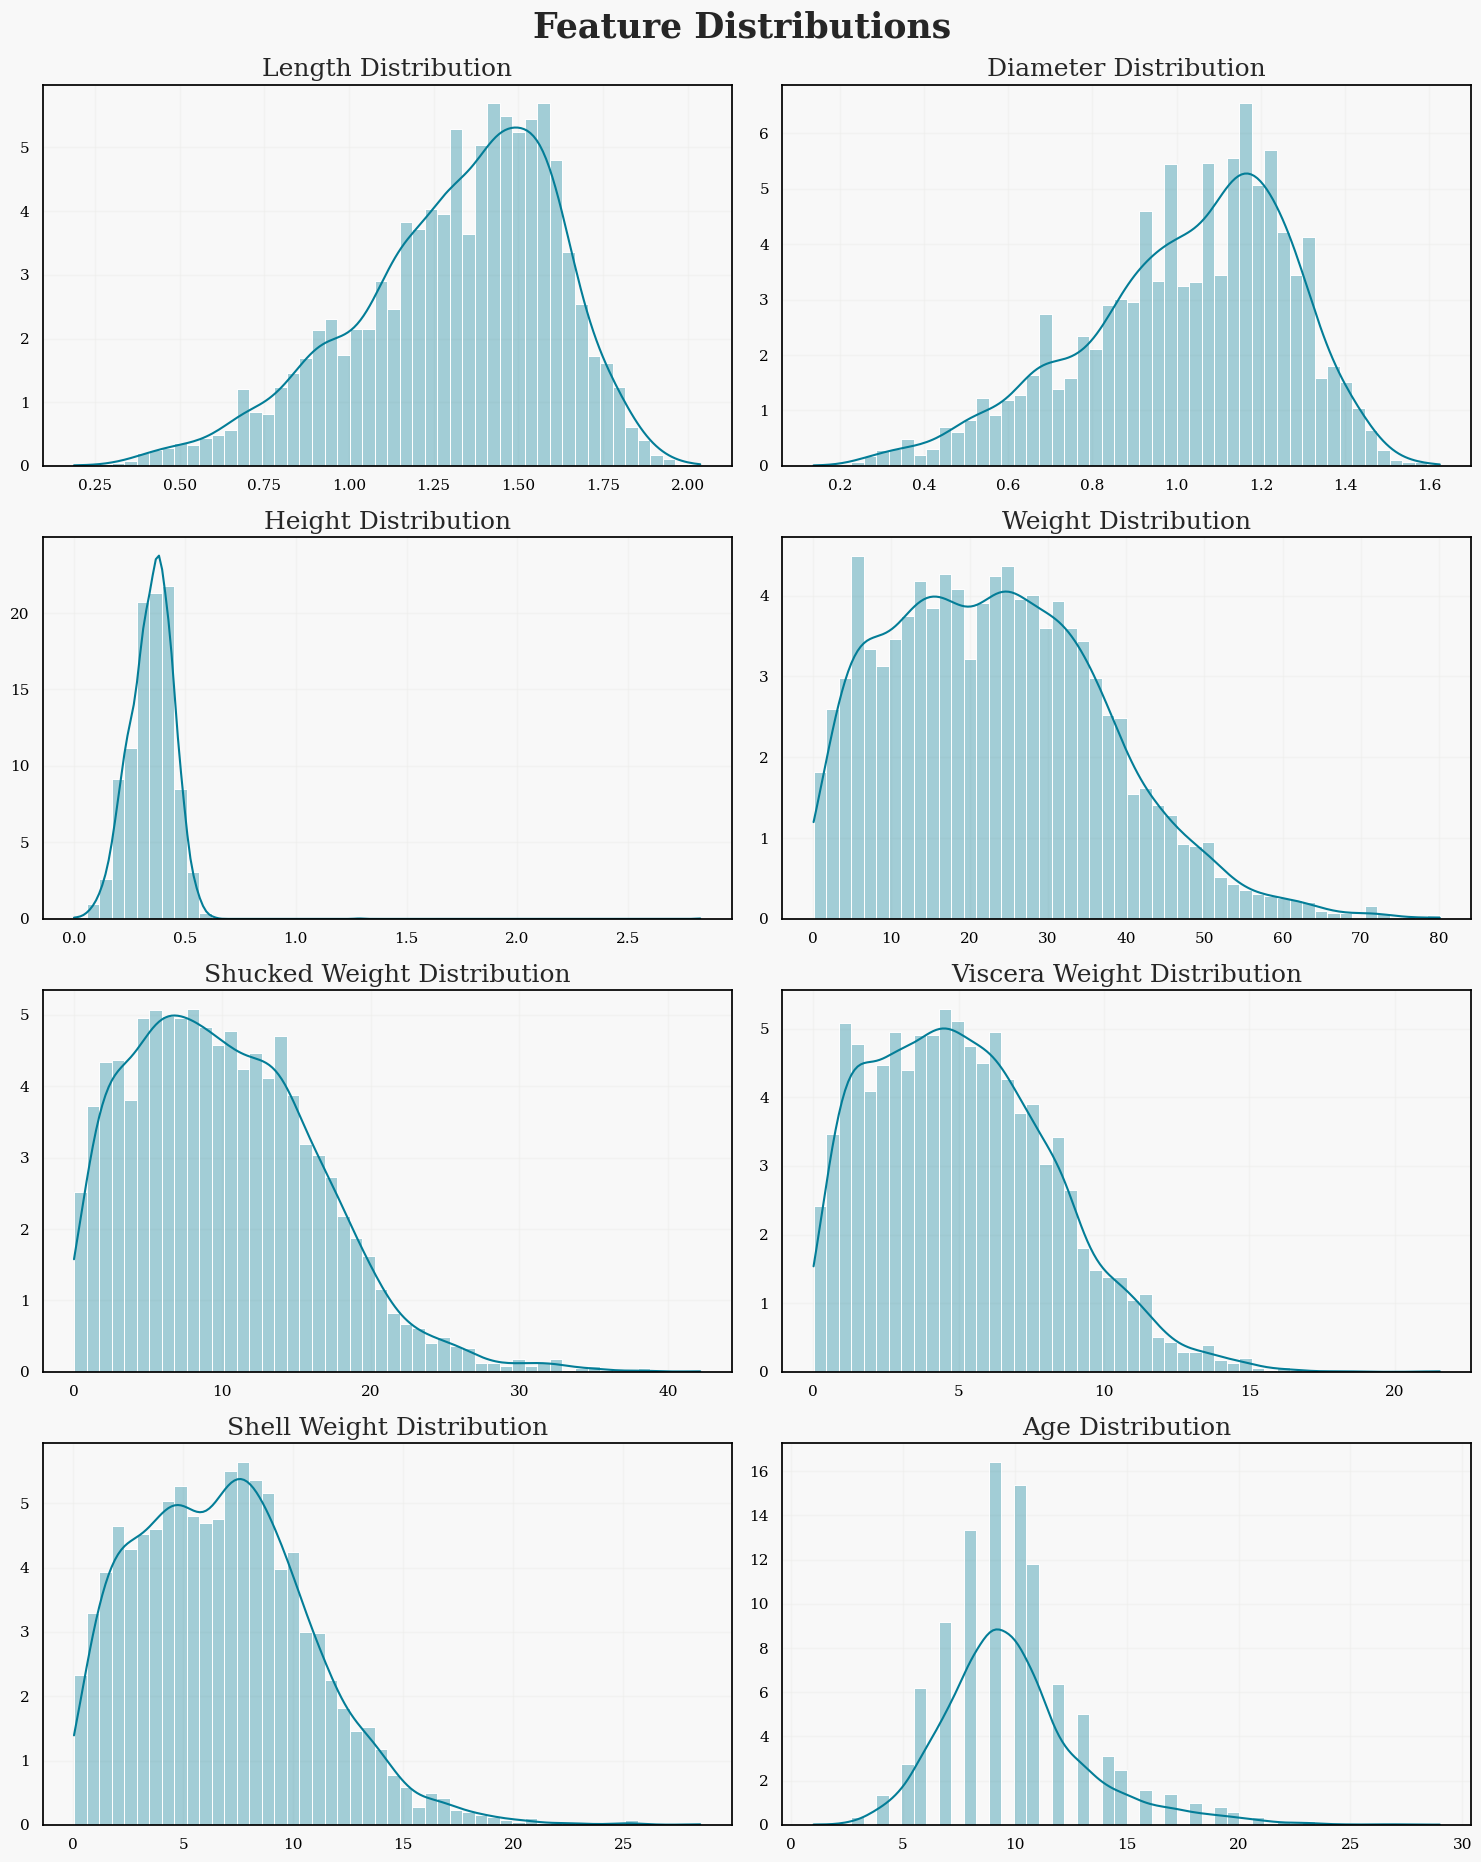

In [7]:
features = [f for f in original.columns if f != 'Sex']
n_bins = 50
histplot_hyperparams = {
    'kde': True,
    'alpha': 0.35,
    'stat': 'percent',
    'bins': n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 20))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]

    sns.histplot(
        original[column], label='Original',
        ax=ax[i], color=palette[1],
        **histplot_hyperparams
    )
        
    for artist in plot_axes[0].artists:
        if isinstance(artist, sns.kdeplot):
            artist.remove()

    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)  
    ax[i].set_ylabel(None, fontsize=16)
    
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions\n\n\n', ha='center', fontweight='bold', fontsize=25, y=0.93)
plt.tight_layout()
plt.show()

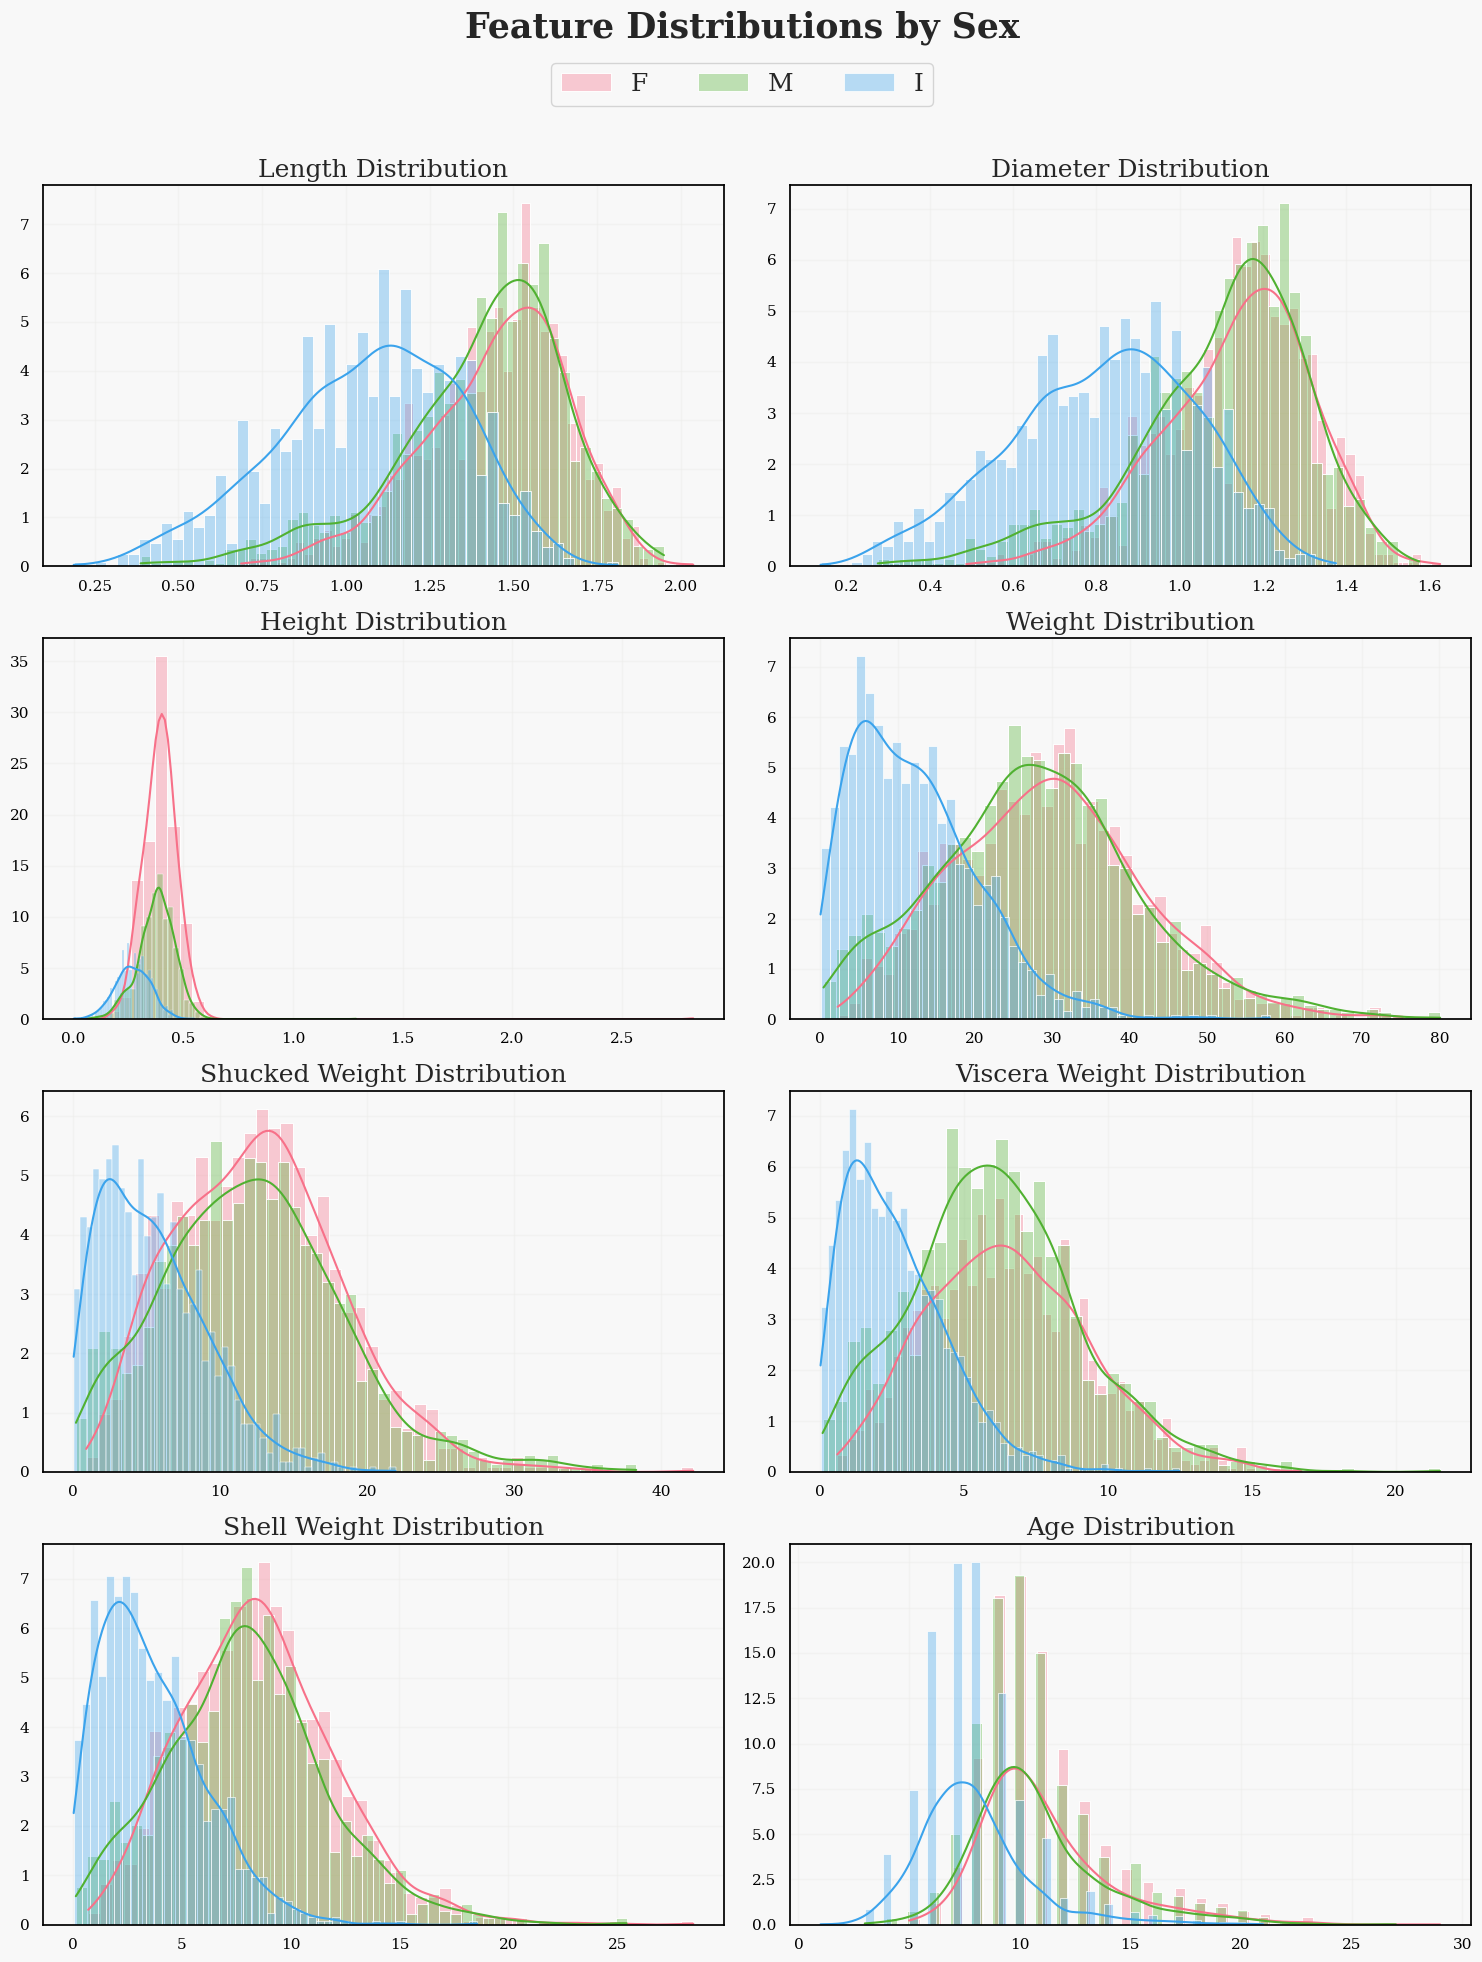

In [8]:
features = [f for f in original.columns if f != 'Sex']
n_bins = 50
histplot_hyperparams = {
    'kde': True,
    'alpha': 0.35,
    'stat': 'percent',
    'bins': n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 20))
ax = ax.flatten()

unique_sex = original['Sex'].unique()
n_categories = len(unique_sex)
colors = sns.color_palette('husl', n_categories)
legend_labels = []

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    legend_labels.clear()
    
    for j, sex in enumerate(unique_sex):
        sns.histplot(
            original[column][original['Sex'] == sex], label=sex,
            ax=ax[i], color=colors[j % n_categories], **histplot_hyperparams
        )
        
        legend_labels.append(sex)
        
        for artist in plot_axes[0].artists:
            if isinstance(artist, sns.kdeplot):
                artist.remove()

    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)
    
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions by Sex\n\n\n', ha='center', fontweight='bold', fontsize=25, y=0.98)
fig.legend(handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=18, ncol=3)
plt.tight_layout()
plt.show()

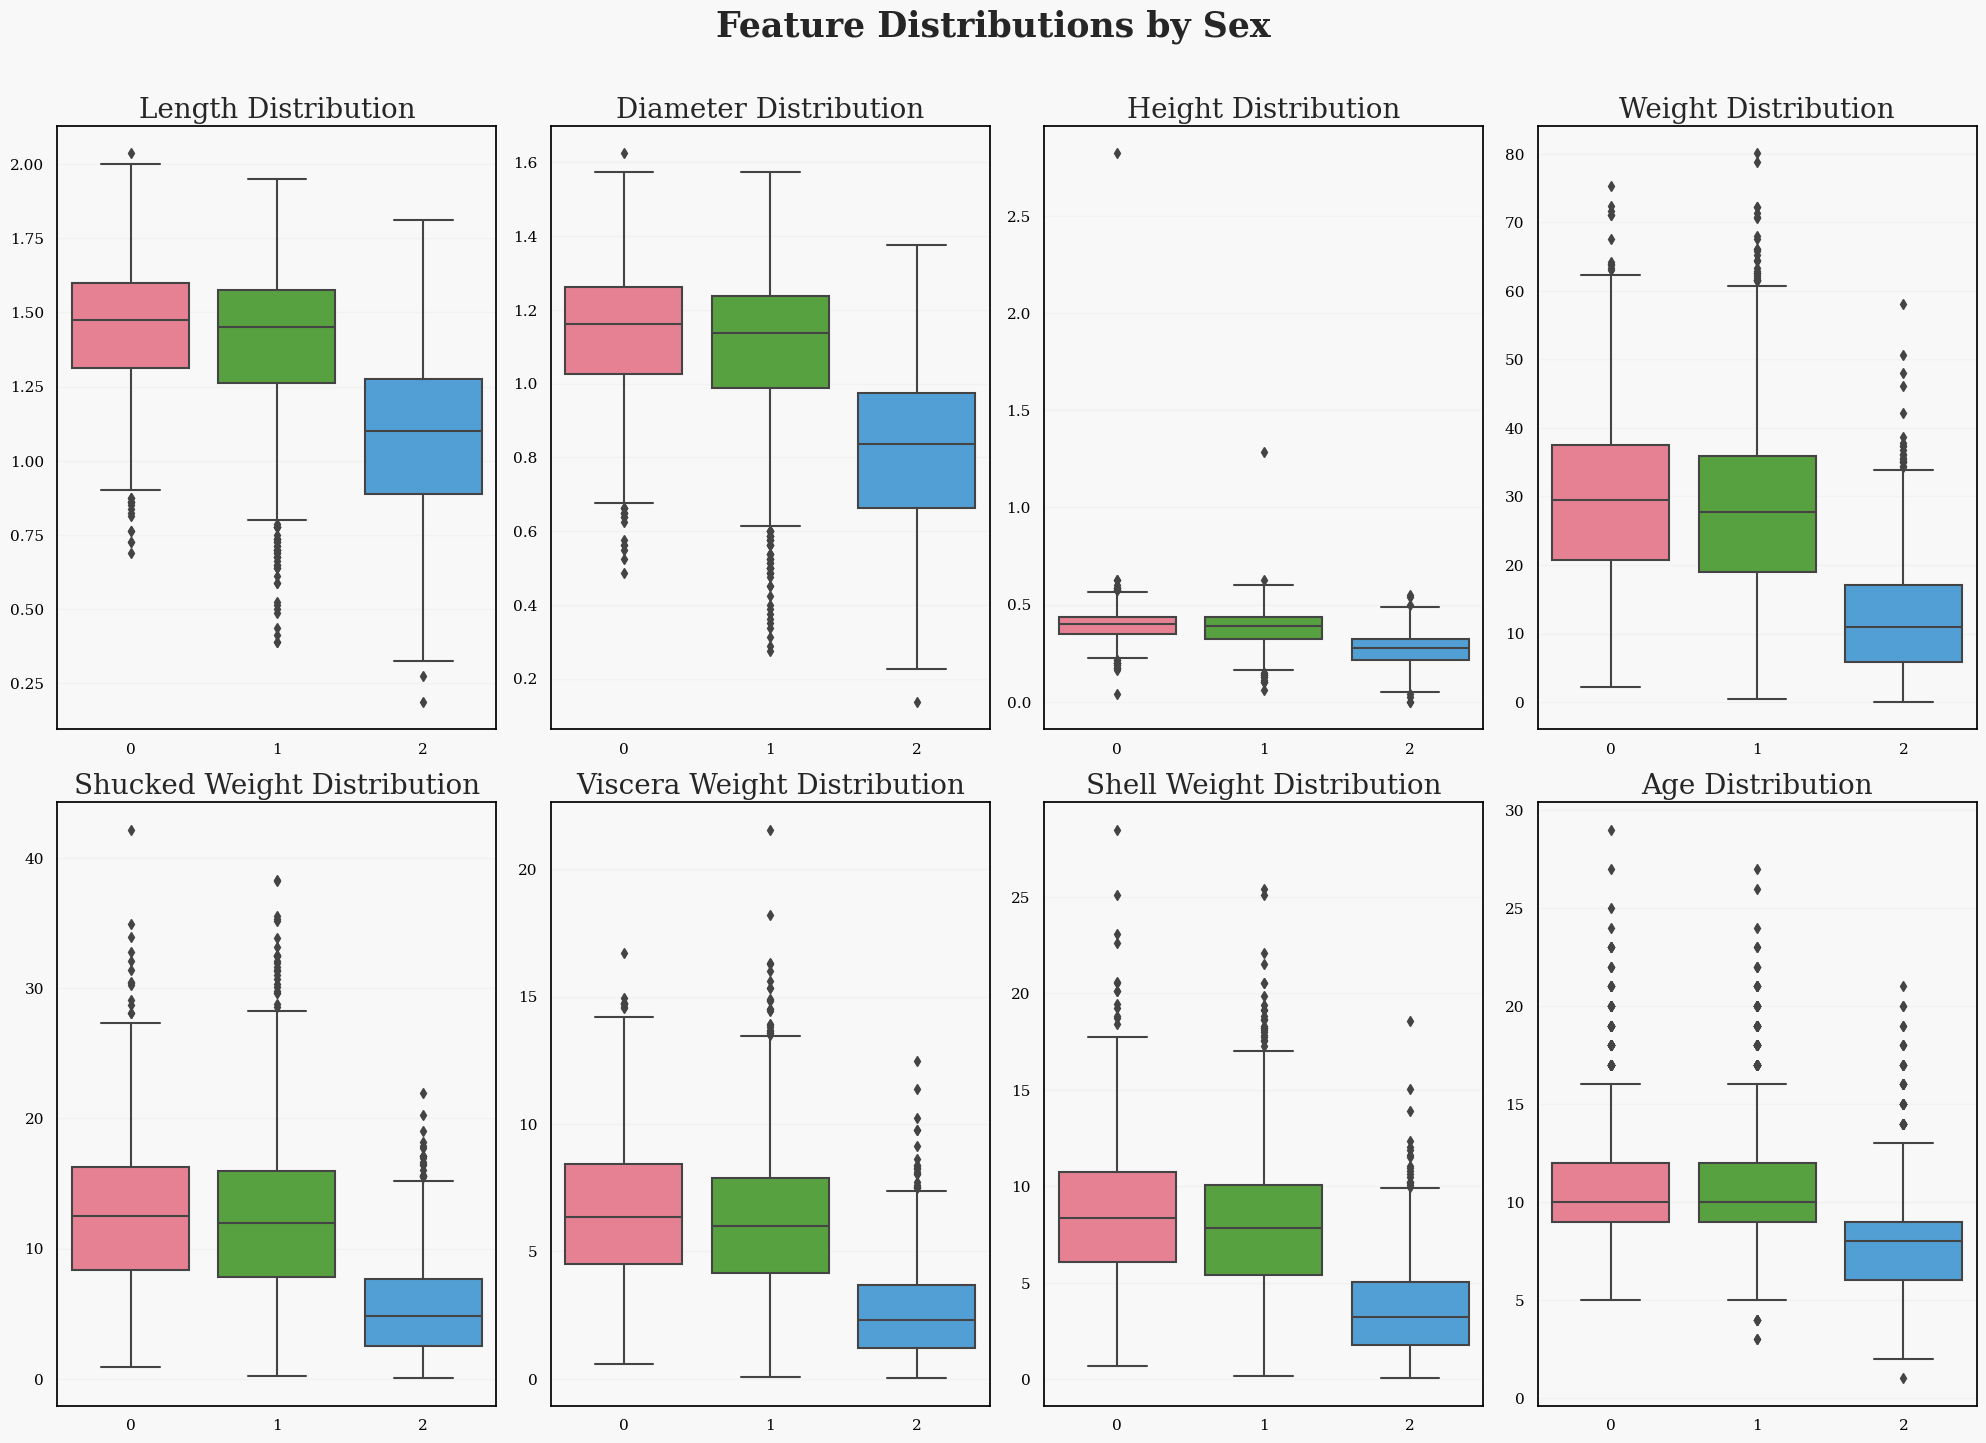

In [9]:
n_rows = len(columns) // 4
if len(columns) % 4:
    n_rows += 1

fig, ax = plt.subplots(n_rows, 4, figsize=(20, 15))
ax = ax.ravel()

unique_sex = original['Sex'].unique()
n_categories = len(unique_sex)
colors = sns.color_palette('husl', n_categories)

for i, column in enumerate(columns):
    data = [original[original['Sex'] == sex][column] for sex in unique_sex]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
  
    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=20)
    ax[i].set_xlabel(None, fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions by Sex\n\n', ha='center', fontweight='bold', fontsize=25, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

* Histograms show slight differences between males and females
* There are some anomalies in the height data that we need to address

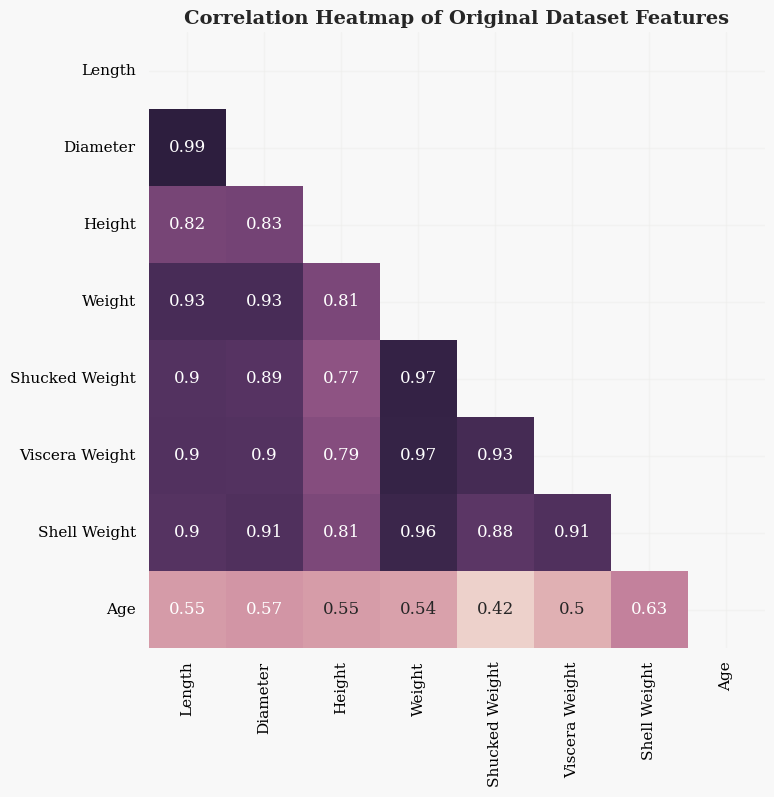

In [10]:
corr_matrix = original.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, square=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)
plt.title("Correlation Heatmap of Original Dataset Features", weight = 'bold', size = 14)
plt.show()

* The features exhibit a high correlation among themselves
* Diameter and Length are identical
* Poor correlation with target suggest that we need to do feature engineering to find a better signal

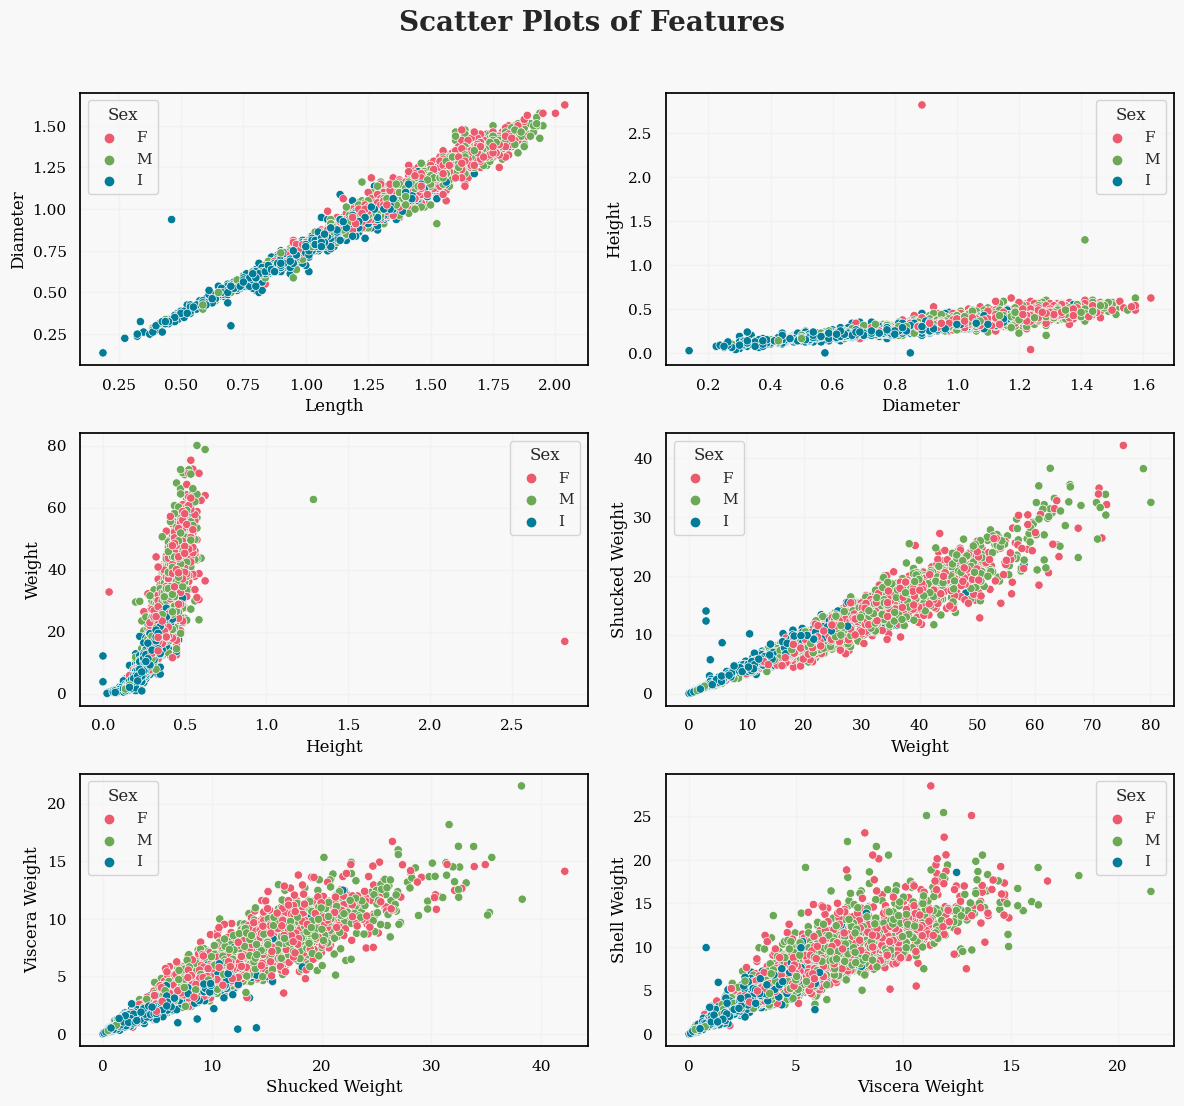

In [11]:
features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

fig = plt.figure(figsize=(12, len(features)//2 * 5))

c = ['#EC5B6D', '#6ca957', '#037d97']

# scatter plots for each pair of features
for i in range(len(features) - 1):
    ax = fig.add_subplot(len(features)//2 + len(features)%2, 2, i+1)

    sns.scatterplot(data=original, x=features[i], y=features[i + 1], hue=original['Sex'], ax=ax, palette=c)
    ax.set_xlabel(features[i])
    ax.set_ylabel(features[i + 1])

fig.suptitle(f'Scatter Plots of Features\n\n\n\n', ha='center', fontweight='bold', fontsize=20, y=0.93)
plt.tight_layout()
plt.show()

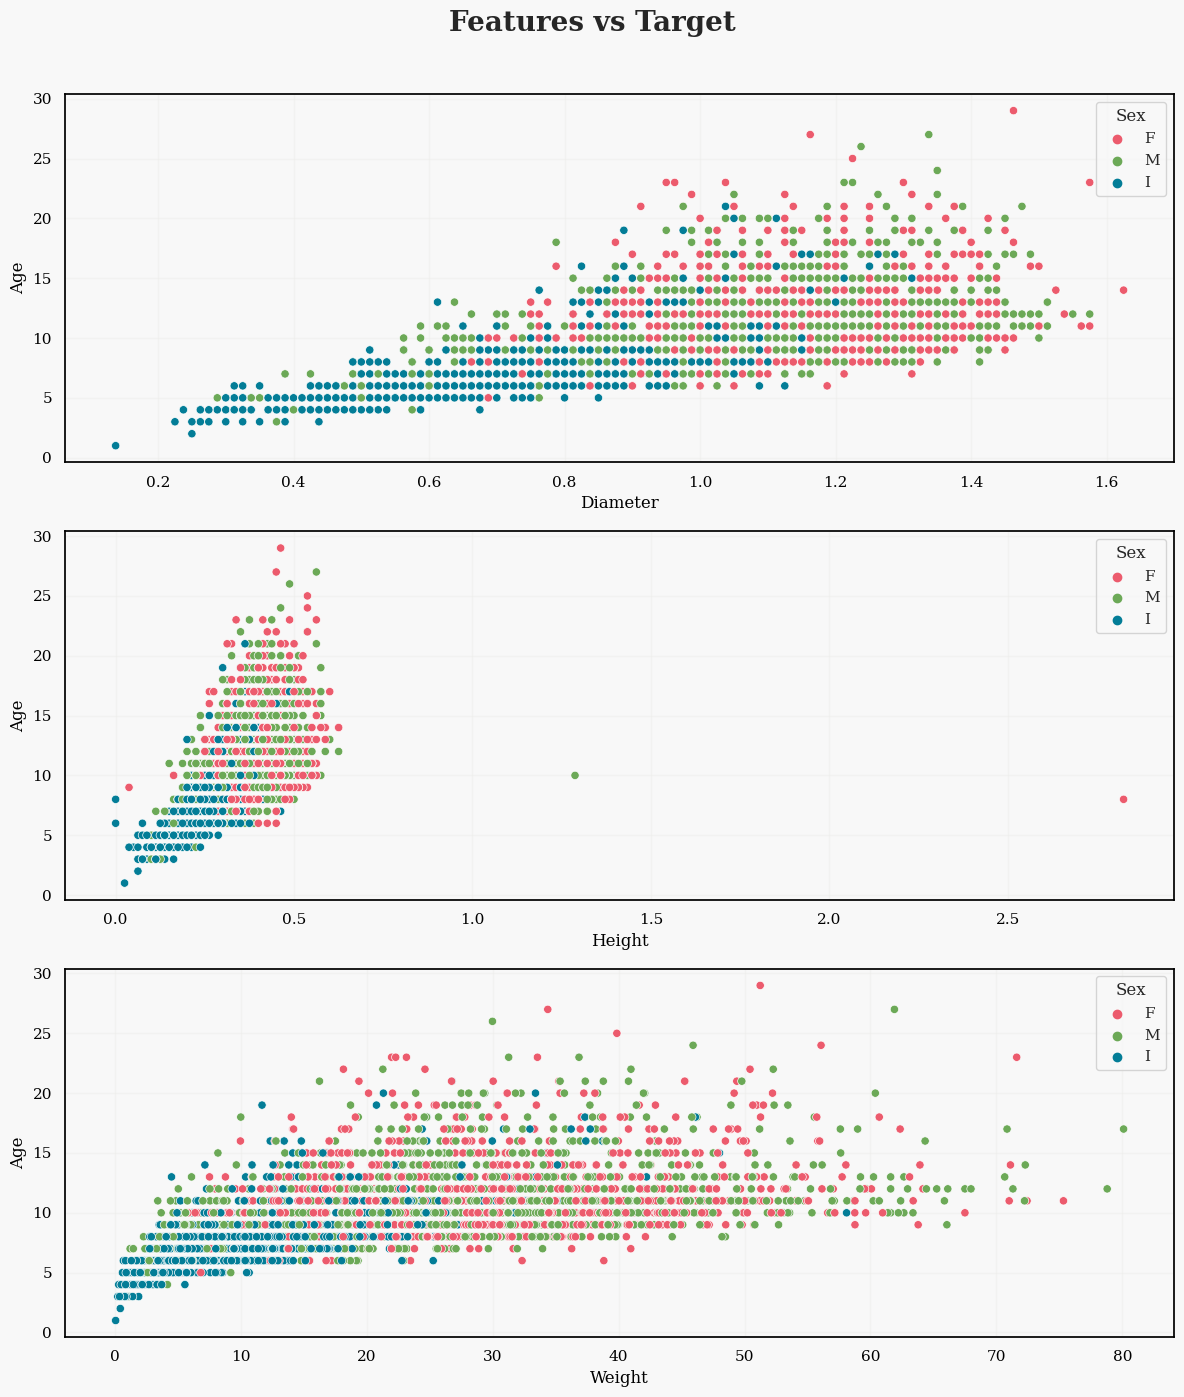

In [12]:
features = ['Diameter', 'Height', 'Weight']

fig = plt.figure(figsize=(12, len(features) * 5))

c = ['#EC5B6D', '#6ca957', '#037d97']

# scatter plots for each feature vs Age
for i in range(len(features)):
    ax = fig.add_subplot(len(features), 1, i+1)

    sns.scatterplot(data=original, x=features[i], y=original['Age'], hue=original['Sex'], ax=ax, palette=c)
    ax.set_xlabel(features[i])
    ax.set_ylabel('Age')

fig.suptitle(f'Features vs Target\n\n\n\n', ha='center', fontweight='bold', fontsize=20, y=0.93)
plt.tight_layout()
plt.show()

In [13]:
original = original.drop([3867, 269, 748, 2256]).reset_index(drop=True)

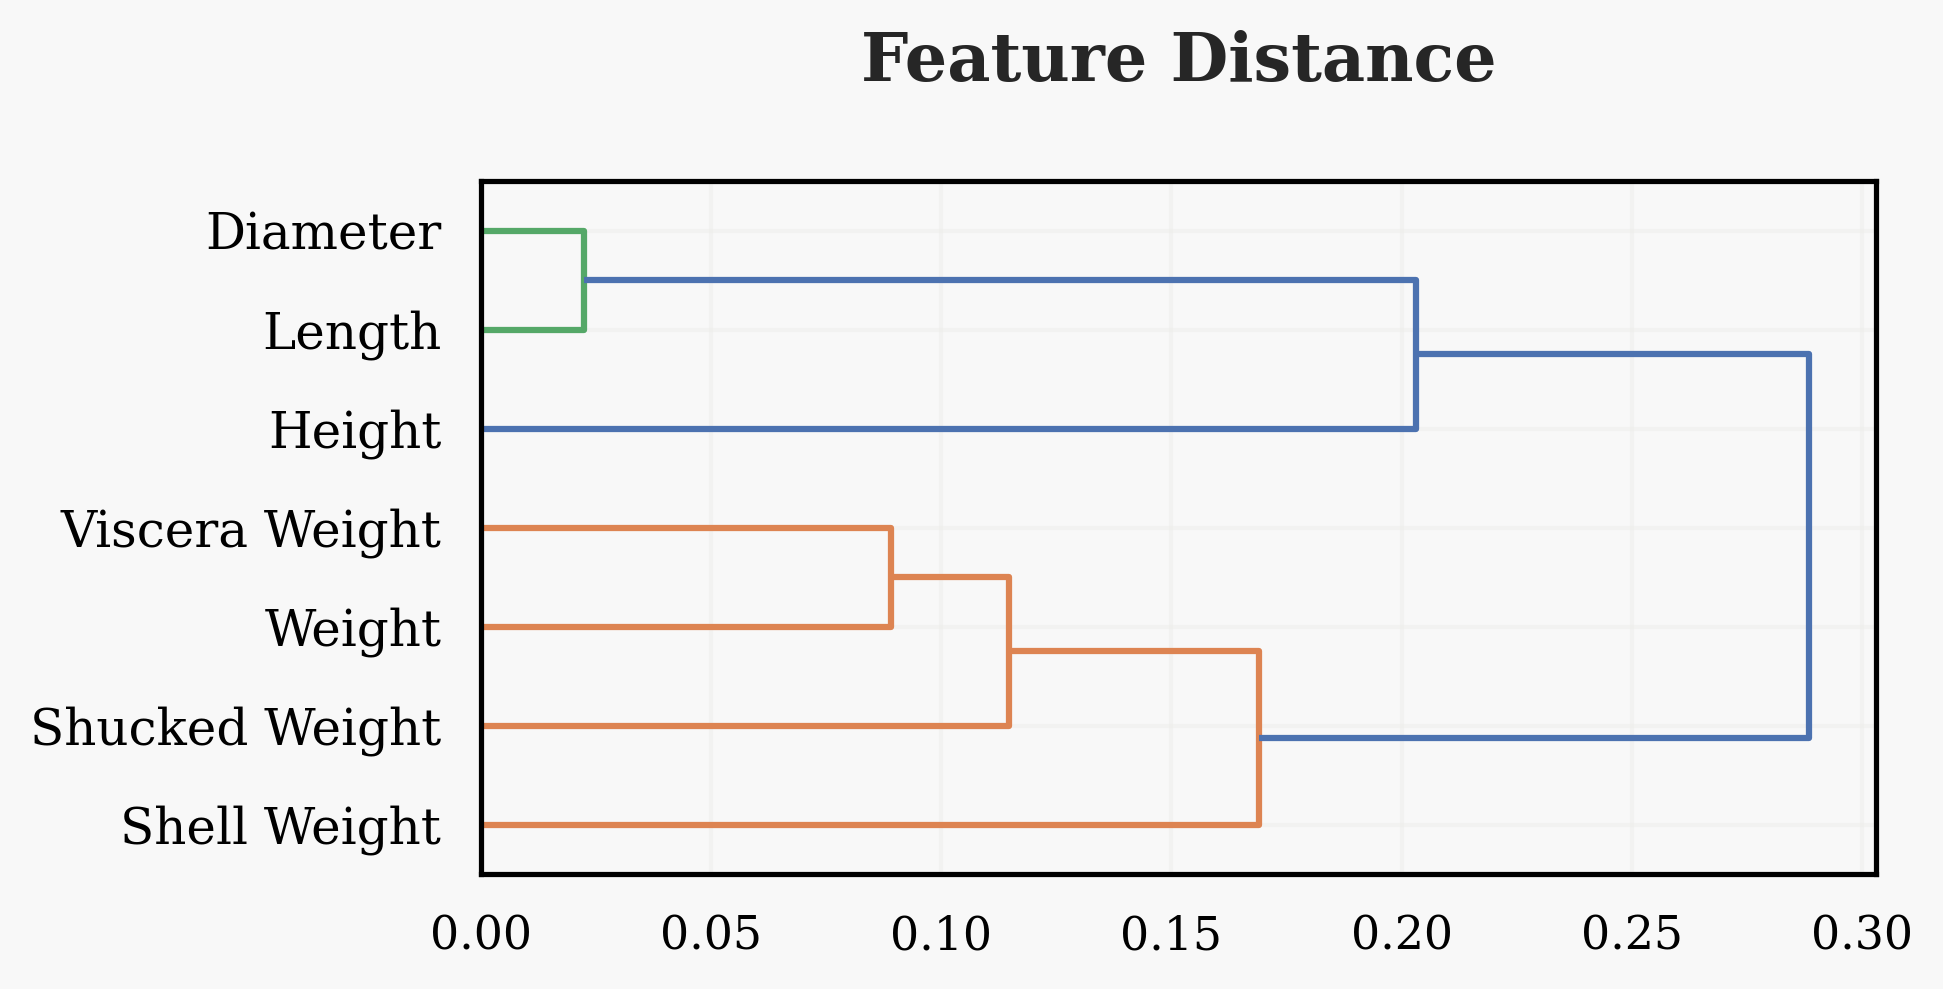

In [14]:
from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import dendrogram

features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

distances = original[features].corr()
dist_linkage = ward(distances)

plt.figure(figsize = (6, 3), dpi = 300)
dendro = dendrogram(dist_linkage, labels=features, leaf_rotation=0, orientation='right')

plt.title(f'Feature Distance\n', weight = 'bold', size = 16)
plt.show()

* As expected, the "weight family" is very close
* Height is the only feature in this dataset that is completely different from other features

In [15]:
from sklearn.feature_selection import mutual_info_regression

mutual_df = original[features]
y = original['Age']

mutual_info = mutual_info_regression(mutual_df, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["MI_score"] ).style.background_gradient("BuGn")

**Mutual Information**: measures the amount of information that can be obtained about the target by knowing a given feature. It captures both linear and nonlinear relationships.

In [16]:
from scipy.stats import entropy

conditional_entropy_scores = []

for feature in features:
    X = original[feature]
    Y = original['Age']

    # joint probability distribution of X and Y
    joint_probs = pd.crosstab(X, Y, normalize='all').values.flatten()
    joint_probs /= joint_probs.sum()  # normalize after flattening to ensure a valid distribution

    # joint entropy of X and Y
    joint_entropy = entropy(joint_probs, base=2)  # specify base as per your use case

    # probability distribution of Y
    if Y.dtype in [np.int64, np.int32, np.float64, np.float32]:  # handling continuous variables
        Y_probs = Y.value_counts(normalize=True, bins=10).sort_index().values
    else:
        Y_probs = Y.value_counts(normalize=True).sort_index().values

    # entropy of Y
    entropy_Y = entropy(Y_probs, base=2)  # specify base as per your use case

    # probability distribution of X
    X_probs = X.value_counts(normalize=True).sort_index().values

    # entropy of X
    entropy_X = entropy(X_probs, base=2)  # specify base as per your use case

    # conditional entropy of Y given X
    conditional_entropy = joint_entropy - entropy_X
    conditional_entropy_scores.append(conditional_entropy)

# conditional entropy scores
conditional_entropy_df = pd.DataFrame(conditional_entropy_scores, index=features, columns=["CI_score"])
conditional_entropy_df = conditional_entropy_df.sort_values(by="CI_score", ascending=False)
conditional_entropy_df_s = conditional_entropy_df.style.background_gradient("BuGn")

conditional_entropy_df_s

**Conditional Entropy**: quantifies how much additional information is required to describe the target when a given feature is known

Shell Weight seems to be a promising feature for this problem for the following reasons:
* Highest correlation with target "Age"
* Highest mutual information score
* Is the most distant "weight family" feature


## Hipothesis Testing

Tests assumes that the populations from which the samples are drawn follow a normal distribution. However, if the sample sizes are large enough, the Central Limit Theorem helps to approximate the sampling distribution of the mean as normal, even if the underlying population distribution is not exactly normal.

**1) Variance difference between male and female**

In [17]:
from scipy.stats import levene
from prettytable import PrettyTable

m_values = original.loc[original['Sex'] == 'M']
f_values = original.loc[original['Sex'] == 'F']

feature_columns = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']

results = {}
for feature in feature_columns:
    stat, p_value = levene(m_values[feature], f_values[feature])
    strong_evidence = 'Yes' if p_value < 0.05 else 'No'
    results[feature] = {'statistic': stat, 'p-value': p_value, 'Significant': strong_evidence}

results_table = PrettyTable()
results_table.field_names = ['Feature', 'Statistic', 'P-value', 'Significant']

for feature, result in results.items():
    results_table.add_row([feature, result['statistic'], result['p-value'], result['Significant']])

print(results_table)

+----------------+--------------------+------------------------+-------------+
|    Feature     |     Statistic      |        P-value         | Significant |
+----------------+--------------------+------------------------+-------------+
|     Length     | 13.883040710609622 | 0.00019860059727830765 |     Yes     |
|    Diameter    | 13.184144951945315 | 0.0002876641621984909  |     Yes     |
|     Height     | 8.272542779533776  |  0.004056985175090916  |     Yes     |
|     Weight     | 4.167778370637901  |  0.041298412735693964  |     Yes     |
| Shucked Weight | 6.938291869294602  |  0.008485932368642554  |     Yes     |
| Viscera Weight | 1.5958539515214802 |  0.20660263643255058   |      No     |
|  Shell Weight  | 1.1610825026216898 |   0.2813390077613214   |      No     |
|      Age       | 0.7342701849192527 |  0.39157985383785265   |      No     |
+----------------+--------------------+------------------------+-------------+


**2) Mean difference between male and female**

In [18]:
from scipy.stats import ttest_ind

m_values = original.loc[original['Sex'] == 'M']
f_values = original.loc[original['Sex'] == 'F']

feature_columns = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']

results = {}
for feature in feature_columns:
    t_stat, p_value = ttest_ind(m_values[feature], f_values[feature], equal_var=False)
    significant = 'Yes' if p_value < 0.05 else 'No'
    results[feature] = {'t-statistic': t_stat, 'p-value': p_value, 'Significant': significant}

results_table = PrettyTable()
results_table.field_names = ['Feature', 't-Statistic', 'P-value', 'Significant']

for feature, result in results.items():
    results_table.add_row([feature, result['t-statistic'], result['p-value'], result['Significant']])

print(results_table)

+----------------+---------------------+------------------------+-------------+
|    Feature     |     t-Statistic     |        P-value         | Significant |
+----------------+---------------------+------------------------+-------------+
|     Length     |  -4.801481817579988 | 1.6623483739937143e-06 |     Yes     |
|    Diameter    |  -5.146177002780261 |  2.85260844255681e-07  |     Yes     |
|     Height     |  -4.951277127270059 | 7.835781593101064e-07  |     Yes     |
|     Weight     | -3.2443557415015842 | 0.0011918485787925188  |     Yes     |
| Shucked Weight | -1.7490338194441968 |  0.08040107174782776   |      No     |
| Viscera Weight |  -3.926603996063028 |  8.83632178692916e-05  |     Yes     |
|  Shell Weight  |  -4.176452311860454 | 3.0576926810794655e-05 |     Yes     |
|      Age       | -3.5136589532069897 | 0.0004496167033734952  |     Yes     |
+----------------+---------------------+------------------------+-------------+


The negative sign indicates that the mean of the males is lower than the mean of the females

## Shell Weight and Diameter

Let's further explore the relationship between Shell Weight and Diameter, as they exhibited favorable mutual and conditional information scores.

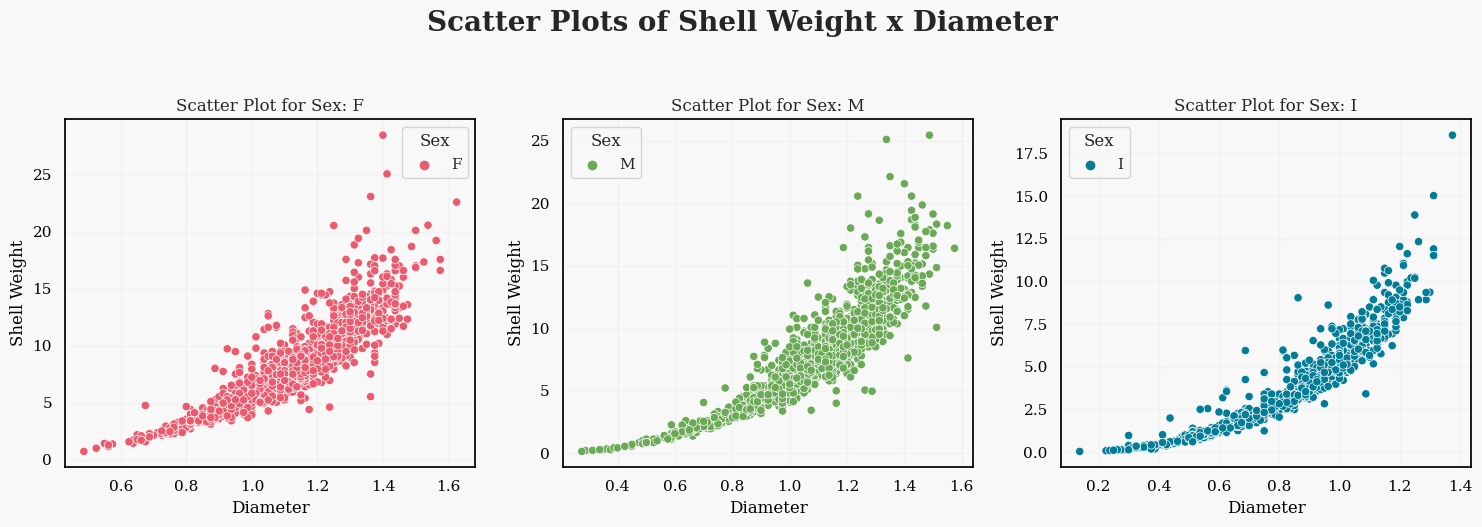

In [19]:
features = ['Diameter', 'Shell Weight']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

c = ['#EC5B6D', '#6ca957', '#037d97']

# Iterate over the sex categories
for i, sex in enumerate(['F', 'M', 'I']):
    ax = axes[i]
    data = original[original['Sex'] == sex] 

    sns.scatterplot(data=data, x=features[0], y=features[1], hue=data['Sex'], ax=ax, palette=[c[i]])
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_title('Scatter Plot for Sex: ' + sex)

fig.suptitle('Scatter Plots of Shell Weight x Diameter', ha='center', fontweight='bold', fontsize=20, y=1.05)
plt.tight_layout()
plt.show()

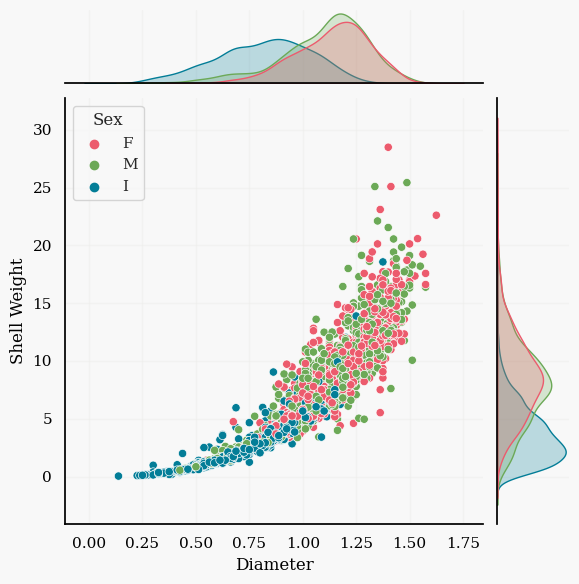

In [20]:
joint = sns.jointplot(data=original, x='Diameter', y='Shell Weight', hue='Sex', palette=c)
joint.set_axis_labels('Diameter', 'Shell Weight')

plt.show()

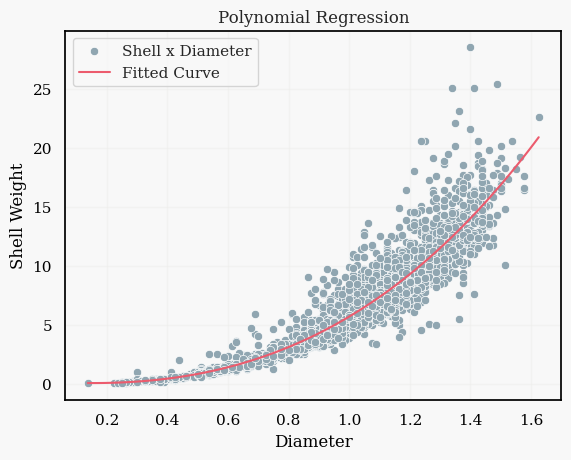

In [21]:
diameter = original['Diameter']
shell_weight = original['Shell Weight']

degree = 3
coefficients = np.polyfit(diameter, shell_weight, degree)
x = np.linspace(diameter.min(), diameter.max(), 100)
y = np.polyval(coefficients, x)

sns.scatterplot(x=diameter, y=shell_weight, color='#90A6B1', label='Shell x Diameter')
plt.plot(x, y, color='#EC5B6D', label='Fitted Curve')
plt.xlabel('Diameter')
plt.ylabel('Shell Weight')
plt.title('Polynomial Regression')
plt.legend()

plt.show()

## Original Data Common Appearances

In [22]:
grouped_data = original.groupby(['Diameter', 'Shell Weight', 'Age', 'Sex']).size()
grouped_data = grouped_data.unstack('Sex')
grouped_data = grouped_data.reset_index()
grouped_data.columns = ['Diameter', 'Shell Weight', 'Age', 'Count_F', 'Count_I', 'Count_M']
grouped_data = grouped_data.fillna(0)
grouped_data['Count'] = (grouped_data['Count_F'] + grouped_data['Count_I'] + grouped_data['Count_M']).astype(int)

common_values = grouped_data[grouped_data['Count'] > 2]
common_values = common_values.sort_values(by='Count', ascending=False)
common_values.style.bar(subset=['Diameter'], color=px.colors.qualitative.Pastel2[7])\
        .background_gradient(subset=['Shell Weight'], cmap='Greens')\
        .background_gradient(subset=['Count_F'], cmap='pink_r')\
        .background_gradient(subset=['Count_I'], cmap='Blues')\
        .background_gradient(subset=['Count_M'], cmap='BuGn')

## Feature Transformation

Let's check for normality. If it's not met, we can try some statistical transformations.

In [23]:
import scipy.stats as stats

features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

for col in features:
    stat, p = stats.shapiro(original[col])
    alpha = 0.05  
    if p > alpha:
        print(f"{col} follows a normal distribution")
    else:
        print(f"{col} does not follow a normal distribution")

Length does not follow a normal distribution
Diameter does not follow a normal distribution
Height does not follow a normal distribution
Weight does not follow a normal distribution
Shucked Weight does not follow a normal distribution
Viscera Weight does not follow a normal distribution
Shell Weight does not follow a normal distribution


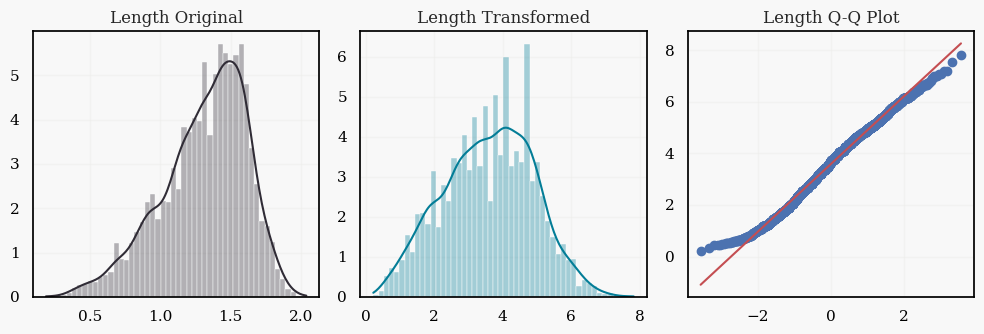

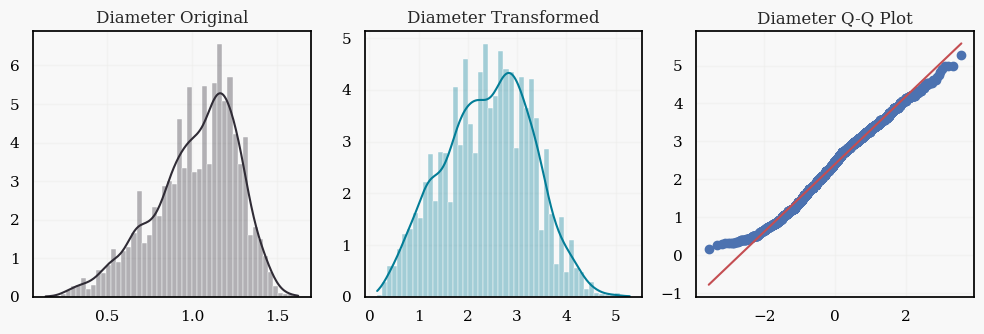

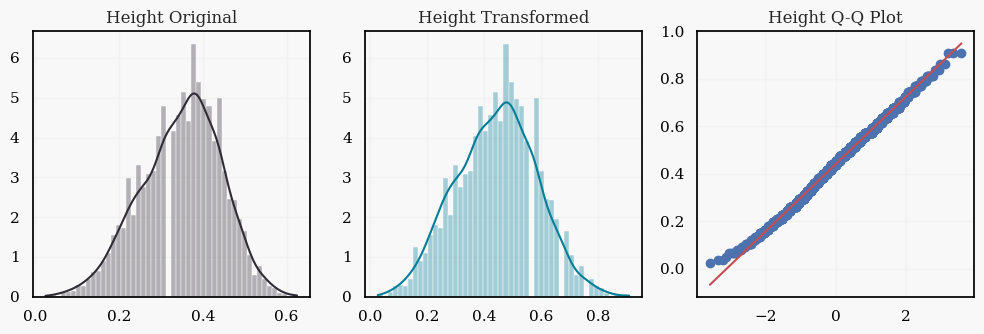

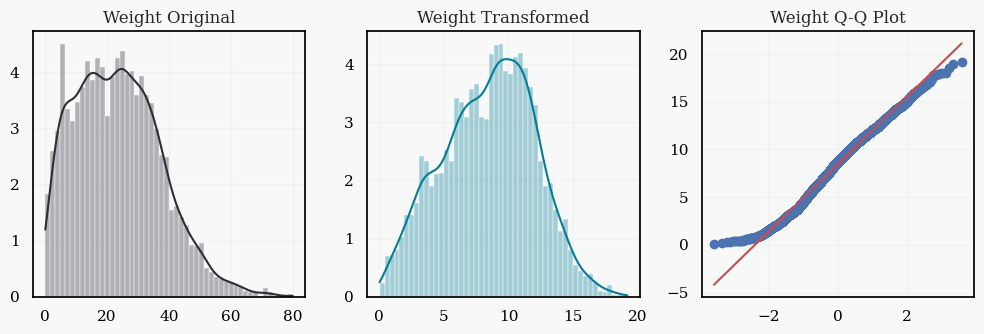

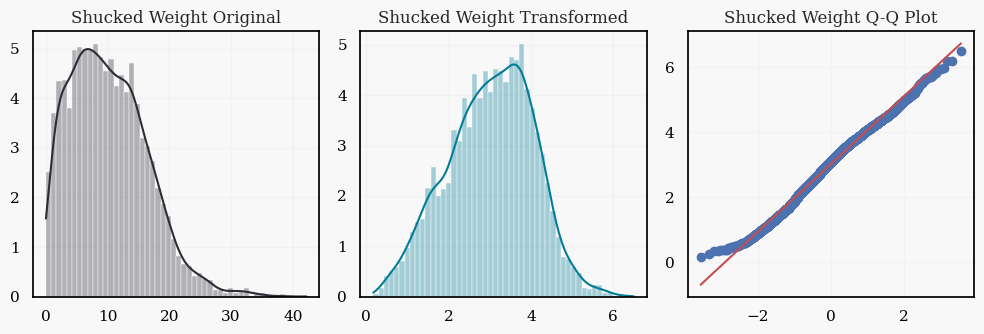

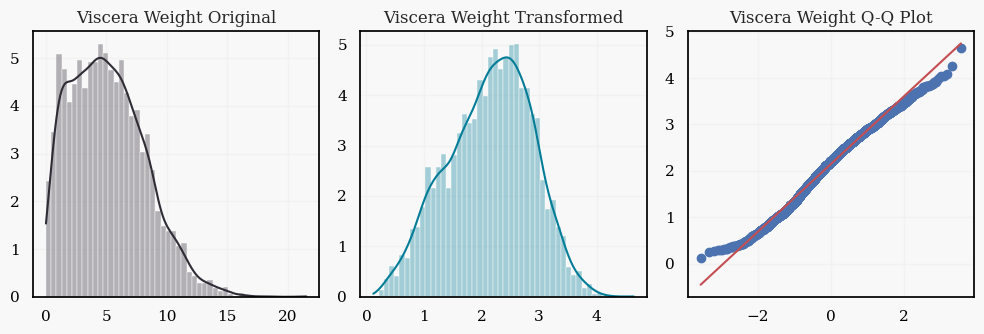

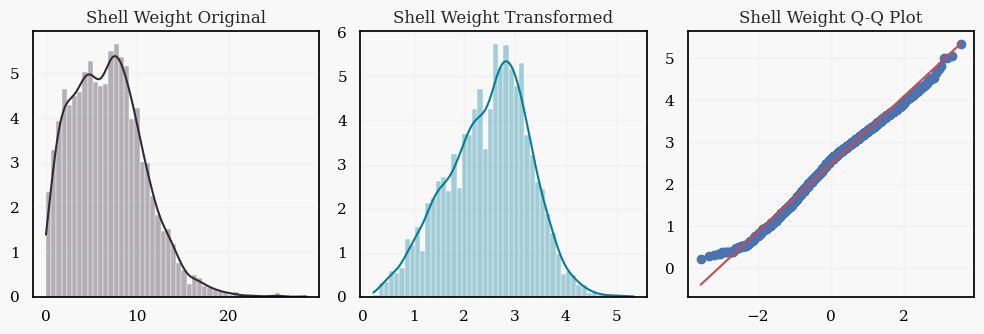

In [24]:
from scipy.stats import yeojohnson

for col in features:
    plt.figure(figsize=(10, 3.5))
    
    # Original Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(
        original[col], color=palette[0],
        **histplot_hyperparams)
    plt.title(f"{col} Original")
    plt.xlabel(None)
    plt.ylabel(None)
    
    # Transformation
    if col in ['Length', 'Diameter', 'Height', 'Weight']:
        transformed_data, lambda_val = yeojohnson(original[col])
    elif col in ['Shucked Weight', 'Viscera Weight', 'Shell Weight']:
        transformed_data = np.power(original[col], 0.5)
        
    plt.subplot(1, 3, 2)
    sns.histplot(transformed_data, color=palette[1],
        **histplot_hyperparams)
    plt.title(f"{col} Transformed")
    plt.xlabel(None)
    plt.ylabel(None)
    
    # Q-Q Plot
    plt.subplot(1, 3, 3)
    stats.probplot(transformed_data, plot=plt)
    plt.title(f"{col} Q-Q Plot")
    plt.xlabel(None)
    plt.ylabel(None)
        
    plt.tight_layout()
    plt.show()

Heavy tails from "weight family" could be partially solved with power transformation

## Synthetic Data

Now it's time to check the actual data for the competition

In [25]:
df.drop(columns='id', inplace=True)
df.head(5)

Sex  Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0   I  1.5250    1.1750  0.3750  28.973189       12.728926        6.647958   
1   I  1.1000    0.8250  0.2750  10.418441        4.521745        2.324659   
2   M  1.3875    1.1125  0.3750  24.777463       11.339800        5.556502   
3   F  1.7000    1.4125  0.5000  50.660556       20.354941       10.991839   
4   I  1.2500    1.0125  0.3375  23.289114       11.977664        4.507570   

   Shell Weight  Age  
0      8.348928    9  
1      3.401940    8  
2      6.662133    9  
3     14.996885   11  
4      5.953395    8

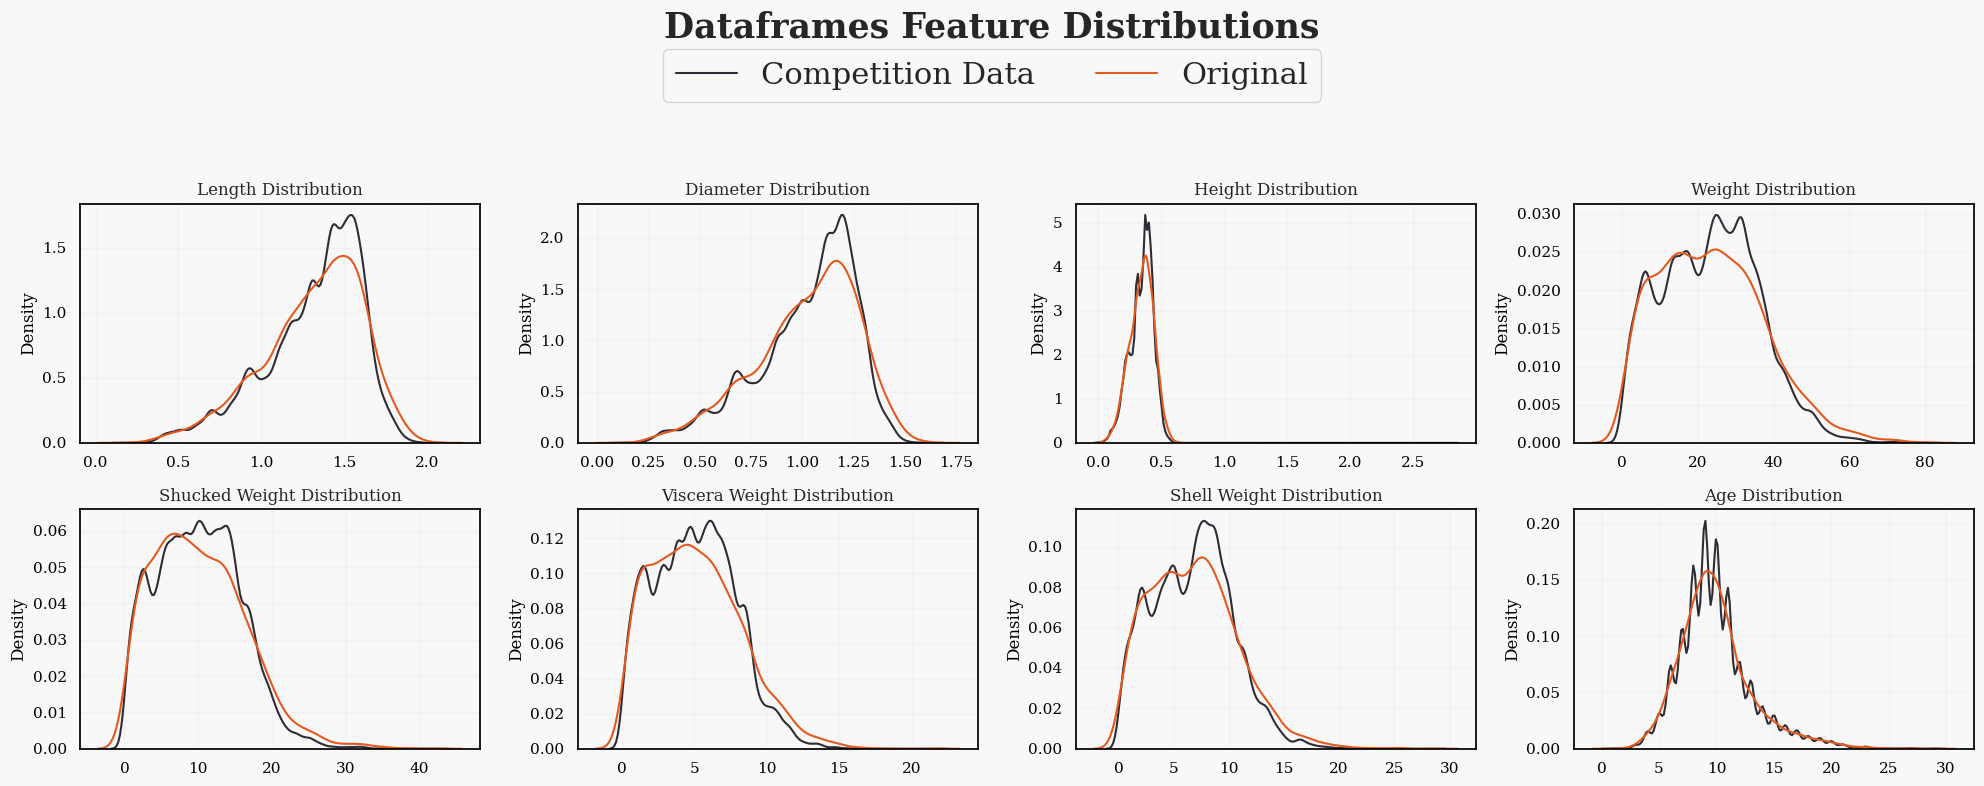

In [26]:
features = [f for f in original.columns if f != 'Sex']
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        df[column], label='Competition Data',
        ax=ax[i], color=palette[0]
    )
    
    sns.kdeplot(
        original[column], label='Original',
        ax=ax[i], color=palette[2]
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataframes Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=22, ncol=3)
plt.tight_layout()

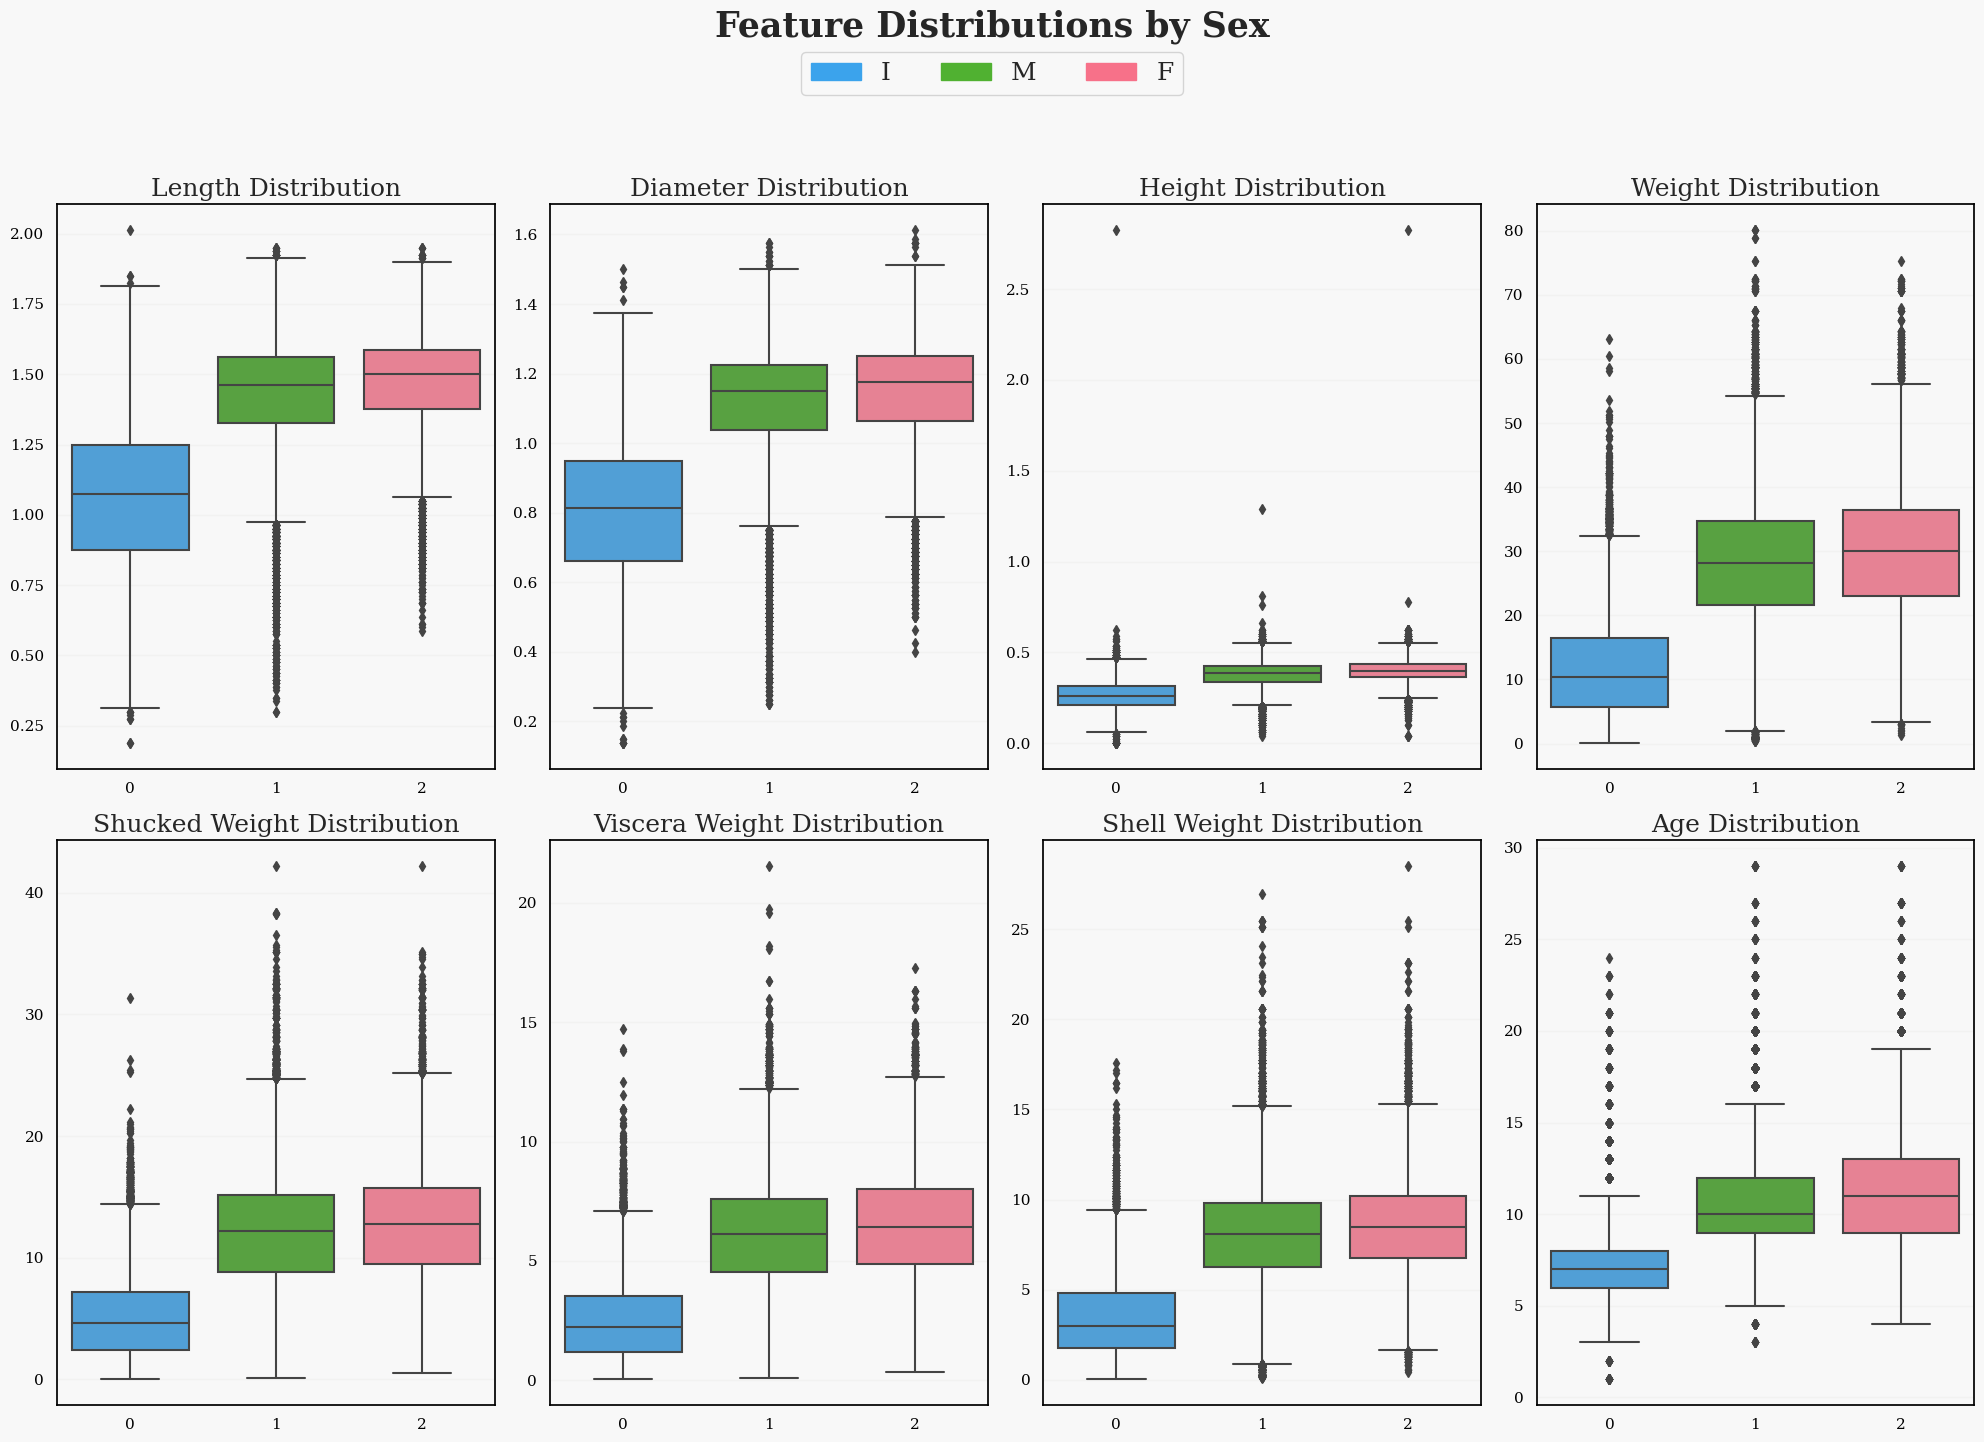

In [27]:
from matplotlib.patches import Patch

c = ['#3ba3ec', '#50b131', '#f77189']

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 15))
ax = ax.flatten()

unique_sex = df['Sex'].unique()
n_categories = len(unique_sex)
colors = sns.color_palette('husl', n_categories)  

for i, column in enumerate(columns):
    data = [df[df['Sex'] == sex][column] for sex in unique_sex]
    sns.boxplot(data=data, ax=ax[i], palette=c)

    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

# create legend
legend_patches = [Patch(color=icolor, label=label) for icolor, label in zip(c, unique_sex)]

fig.suptitle(f'Feature Distributions by Sex\n\n\n\n', ha='center', fontweight='bold', fontsize=25, y=0.96)
fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 0.94), fontsize=18, ncol=3)
plt.tight_layout()
plt.show()

The height variable also exhibits a few anomalies in this dataset

In [28]:
df = df.drop([4704, 55879, 19023]).reset_index(drop=True)

## Feature Engineering

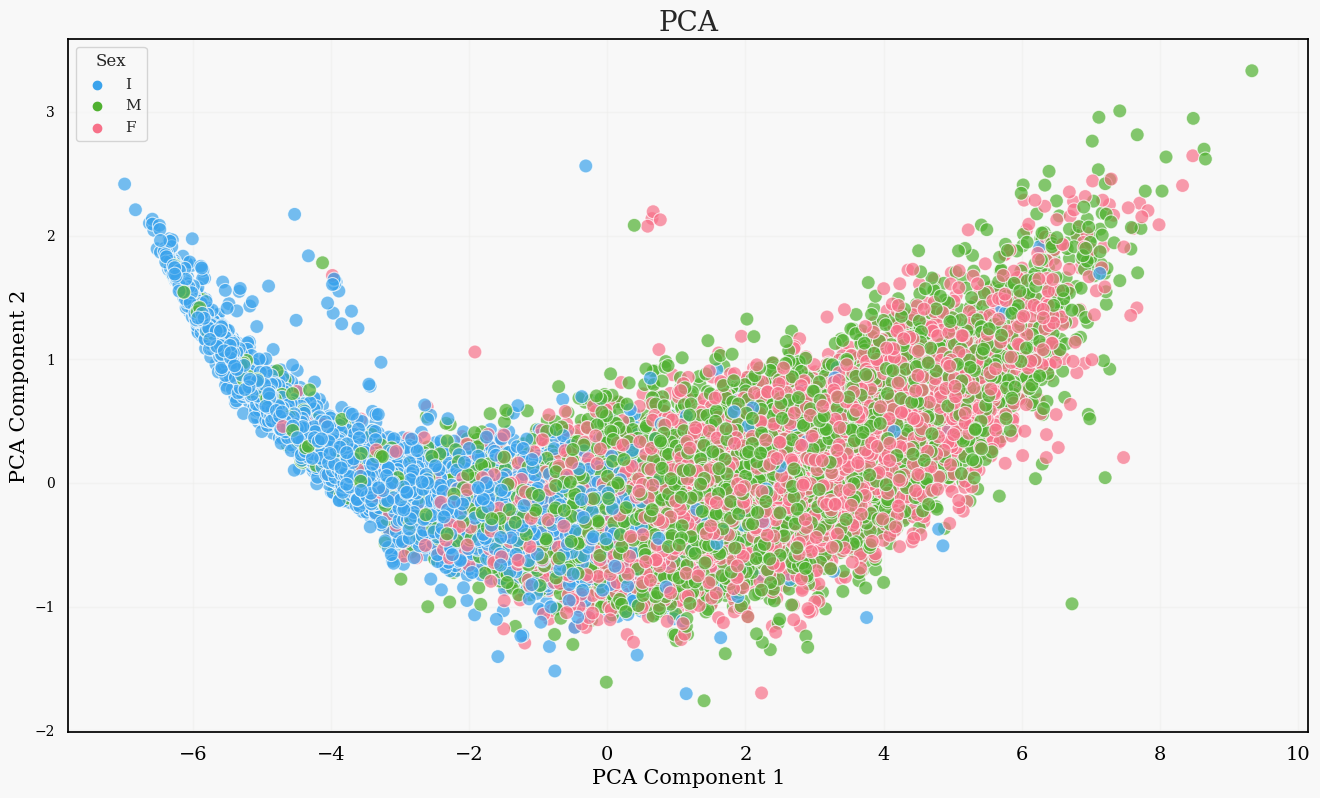

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_copy = df.copy()
test_copy = test.copy()

features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

scaler = StandardScaler()

df_copy[features] = scaler.fit_transform(df_copy[features])
test_copy[features] = scaler.transform(test_copy[features])

df_dropped = df_copy.drop(['Age', 'Sex'], axis=1)
test_dropped = test_copy.drop(['Sex'], axis=1)

pca = PCA(n_components=2, random_state=42)
df_transformed = pca.fit_transform(df_dropped)
test_transformed = pca.transform(test_dropped)

df_transformed = pd.DataFrame(df_transformed, columns=['PCA1', 'PCA2'])
test_transformed = pd.DataFrame(test_transformed, columns=['PCA1', 'PCA2'])

df_transformed = pd.concat([df_copy[['Sex']], df_transformed], axis=1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = df_transformed['PCA1'], y = df_transformed['PCA2'], data=df_transformed, hue='Sex', alpha=0.7, s=100, palette=c);

plt.title('PCA', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("PCA Component 1", fontsize = 15)
plt.ylabel("PCA Component 2", fontsize = 15);

df = pd.concat([df, df_transformed[['PCA1', 'PCA2']]], axis=1)
test = pd.concat([test, test_transformed[['PCA1', 'PCA2']]], axis=1)

In [30]:
df = pd.get_dummies(df, columns=['Sex'])
test = pd.get_dummies(test, columns=['Sex'])

In [31]:
df['water_loss'] = df['Weight'] - df['Viscera Weight'] - df['Shucked Weight'] - df['Shell Weight']
df['shell_ratio'] = df['Shell Weight'] / df['Weight']
df['viscera_ratio'] = df['Viscera Weight'] / df['Weight']
df['shucked_ratio'] = df['Shucked Weight'] / df['Weight']
df['volume'] = (4/3) * np.pi * (df['Length'] / 2) * ((df['Diameter'] + df['Height']) / 4) ** 2
df['shell_height'] = df['Shell Weight'] * df['Height']
df['shucked_height'] = df['Shucked Weight'] * df['Height']

test['water_loss'] = test['Weight'] - test['Viscera Weight'] - test['Shucked Weight'] - test['Shell Weight']
test['shell_ratio'] = test['Shell Weight'] / test['Weight']
test['viscera_ratio'] = test['Viscera Weight'] / test['Weight']
test['shucked_ratio'] = test['Shucked Weight'] / test['Weight']
test['volume'] = (4/3) * np.pi * (test['Length'] / 2) * ((test['Diameter'] + test['Height']) / 4) ** 2
test['shell_height'] = test['Shell Weight'] * test['Height']
test['shucked_height'] = test['Shucked Weight'] * test['Height']

Let's use partial least square regression to check if the transformations that we made in the original dataset could work with the synthetic data

In [32]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
target = 'Age'

table = PrettyTable()
table.field_names = ['Feature', 'R^2']

for feature in features:
    
    X = df[feature].values.reshape(-1, 1)
    y = df[target].values
    
    # Fit the PLS regression model
    pls = PLSRegression(n_components=1)
    pls.fit(X, y)
    
    y_pred = pls.predict(X)
    
    r2 = r2_score(y, y_pred)
    
    table.add_row([feature, r2])

table.sortby = 'R^2'
table.reversesort = True

print(table)

+----------------+---------------------+
|    Feature     |         R^2         |
+----------------+---------------------+
|  Shell Weight  | 0.44019673482665966 |
|     Height     |  0.4163289270500897 |
|    Diameter    |  0.3859544025952104 |
|     Length     |  0.3755714748967527 |
|     Weight     |  0.3614481333539893 |
| Viscera Weight |  0.3327067843996633 |
| Shucked Weight | 0.25334949343018653 |
+----------------+---------------------+


In [33]:
df_copy = df.copy()

table = PrettyTable()
table.field_names = ['Transformed Feature', 'R^2']

for feature in features:
    
    if feature in ['Length', 'Diameter', 'Height', 'Weight']:
        df_copy[feature], _ = yeojohnson(df_copy[feature])
    elif feature in ['Shucked Weight', 'Viscera Weight', 'Shell Weight']:
        df_copy[feature] = np.sqrt(df_copy[feature])
        
    X = df_copy[feature].values.reshape(-1, 1)
    y = df_copy[target].values
    
    # Fit the PLS regression model
    pls = PLSRegression(n_components=1)
    pls.fit(X, y)
    
    y_pred = pls.predict(X)
    
    r2 = r2_score(y, y_pred)
    
    table.add_row([feature, r2])

table.sortby = 'R^2'
table.reversesort = True

print(table)

+---------------------+---------------------+
| Transformed Feature |         R^2         |
+---------------------+---------------------+
|     Shell Weight    | 0.45958839889426173 |
|        Height       | 0.40489539891533377 |
|        Weight       | 0.38293952592135017 |
|    Viscera Weight   | 0.37284382398521465 |
|       Diameter      |  0.3660070591463387 |
|        Length       | 0.35309159182718586 |
|    Shucked Weight   | 0.30322217492222425 |
+---------------------+---------------------+


Apply the transformation only on features which the score improved

In [34]:
for col in df.columns:
    if col in ['Weight']:
        df[col], _ = yeojohnson(df[col])
    elif col in ['Shucked Weight', 'Viscera Weight', 'Shell Weight']:
        df[col] = np.sqrt(df[col])

for col in test.columns:
    if col in ['Weight']:
        test[col], _ = yeojohnson(test[col])
    elif col in ['Shucked Weight', 'Viscera Weight', 'Shell Weight']:
        test[col] = np.sqrt(test[col])

In [35]:
# we can drop Diameter or Lenght
df = df.drop('Diameter', axis=1)
test = test.drop('Diameter', axis=1)

In [36]:
df.head()

Length  Height     Weight  Shucked Weight  Viscera Weight  Shell Weight  \
0  1.5250  0.3750  14.158481        3.567762        2.578363      2.889451   
1  1.1000  0.2750   6.473197        2.126440        1.524683      1.844435   
2  1.3875  0.3750  12.588289        3.367462        2.357223      2.581111   
3  1.7000  0.5000  21.440730        4.511645        3.315394      3.872581   
4  1.2500  0.3375  12.013489        3.460876        2.123104      2.439958   

   Age      PCA1      PCA2  Sex_F  Sex_I  Sex_M  water_loss  shell_ratio  \
0    9  1.356198 -0.045047      0      1      0    1.247378     0.288160   
1    8 -2.390434 -0.233510      0      1      0    0.170097     0.326531   
2    9  0.529023 -0.184006      0      0      1    1.219029     0.268879   
3   11  4.932893  0.592069      1      0      0    4.316891     0.296027   
4    8 -0.184385  0.216610      0      1      0    0.850485     0.255630   

   viscera_ratio  shucked_ratio    volume  shell_height  shucked_height  
0       0.229452       0.439335  0.479592      3.130848        4.773347  
1       0.223129       0.434014  0.174227      0.935534        1.243480  
2       0.224256       0.457666  0.401870      2.498300        4.252425  
3       0.216970       0.401791  0.813936      7.498443       10.177471  
4       0.193548       0.514303  0.298206      2.009271        4.042462

## Model

In [37]:
# Base Model

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score

X = df.drop('Age', axis=1)
y = df['Age']

model = LGBMRegressor()

# Cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))

print(f"Mean Absolute Error (MAE) in Cross Validation: {scores.mean()}")

Mean Absolute Error (MAE) in Cross Validation: 1.4075450054658898


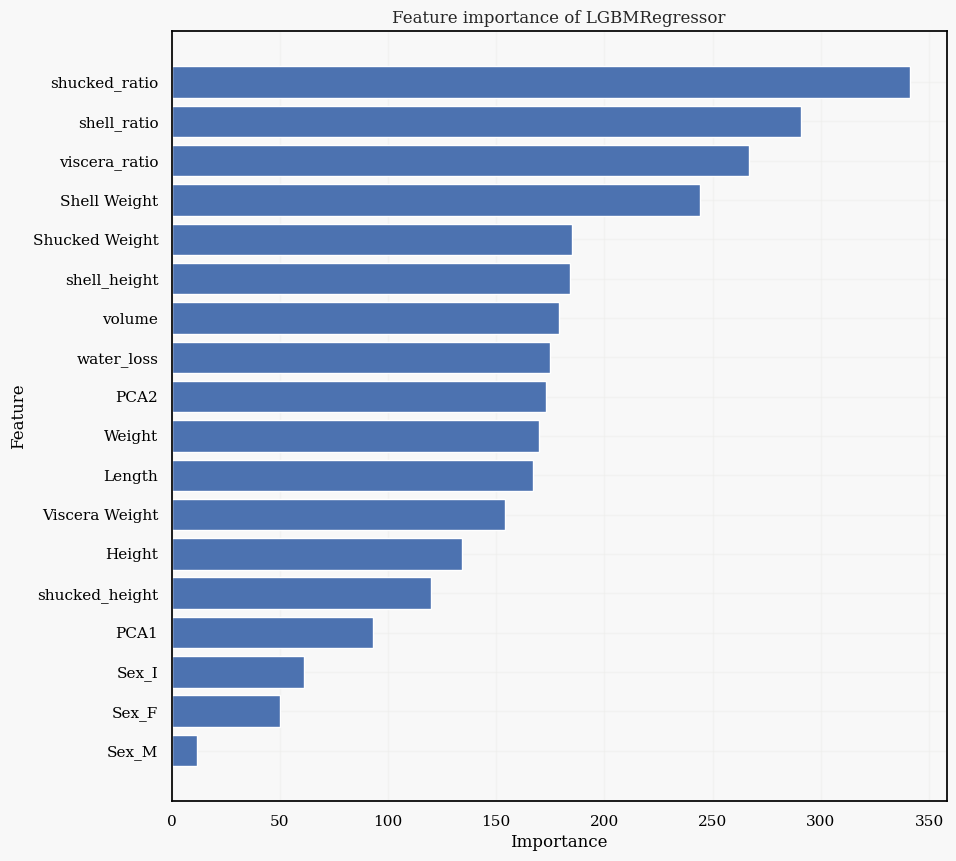

In [38]:
model.fit(X, y)
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance of LGBMRegressor')
plt.gca().invert_yaxis()
plt.show()

In [39]:
# Improved model

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

X = df.drop('Age', axis=1)
y = df['Age']
oof = np.zeros(len(y)) 

lgb_params = {
    'objective': 'regression_l1',
    'metric': 'l1',
    'boosting': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 76,
    'lambda_l1': 9.175161417359635,
    'lambda_l2': 0.9700145667850508,
    'bagging_freq': 3,
    'bagging_fraction':0.9302033390450073,
    'feature_fraction': 0.85,
    'min_child_samples': 100,   
    'num_iterations': 700,
    'seed': 42,
    'force_col_wise':True,
    'feature_pre_filter':False,
    'verbosity':-1,
    'early_stopping_round' : 100
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []
accuracies = []
models = []
eval_results_list = []

for i, (train_index, val_index) in enumerate(skf.split(X, df['Age'])):
    print(f'\nFold # {i}')
    print('*'*26)
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_dataset = lgb.Dataset(X_train, label=y_train)
    eval_dataset = lgb.Dataset(X_val, label=y_val)
    
    eval_results = {}

    model = lgb.train(
        params=lgb_params,
        train_set=train_dataset,
        num_boost_round=10000,
        valid_sets=[train_dataset, eval_dataset],
        verbose_eval=False,
        evals_result=eval_results
    )
    
    models.append(model)
    eval_results_list.append(eval_results)

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    cv_scores.append(mae)        
    
    accuracy = r2_score(y_val, y_pred)
    accuracies.append(accuracy)
    
    oof[val_index] = model.predict(X_val)

oof_df = pd.DataFrame(np.vstack([oof, y]).T, columns=['Age_pred', 'Age'])
mean_cv_score = sum(cv_scores) / len(cv_scores)
mean_accuracy = sum(accuracies) / len(accuracies)

print("Mean CV MAE Score: {:.4f}".format(mean_cv_score))
print("Mean Accuracy (R-squared): {:.4f}".format(mean_accuracy))


Fold # 0
**************************

Fold # 1
**************************

Fold # 2
**************************

Fold # 3
**************************

Fold # 4
**************************
Mean CV MAE Score: 1.3521
Mean Accuracy (R-squared): 0.5700


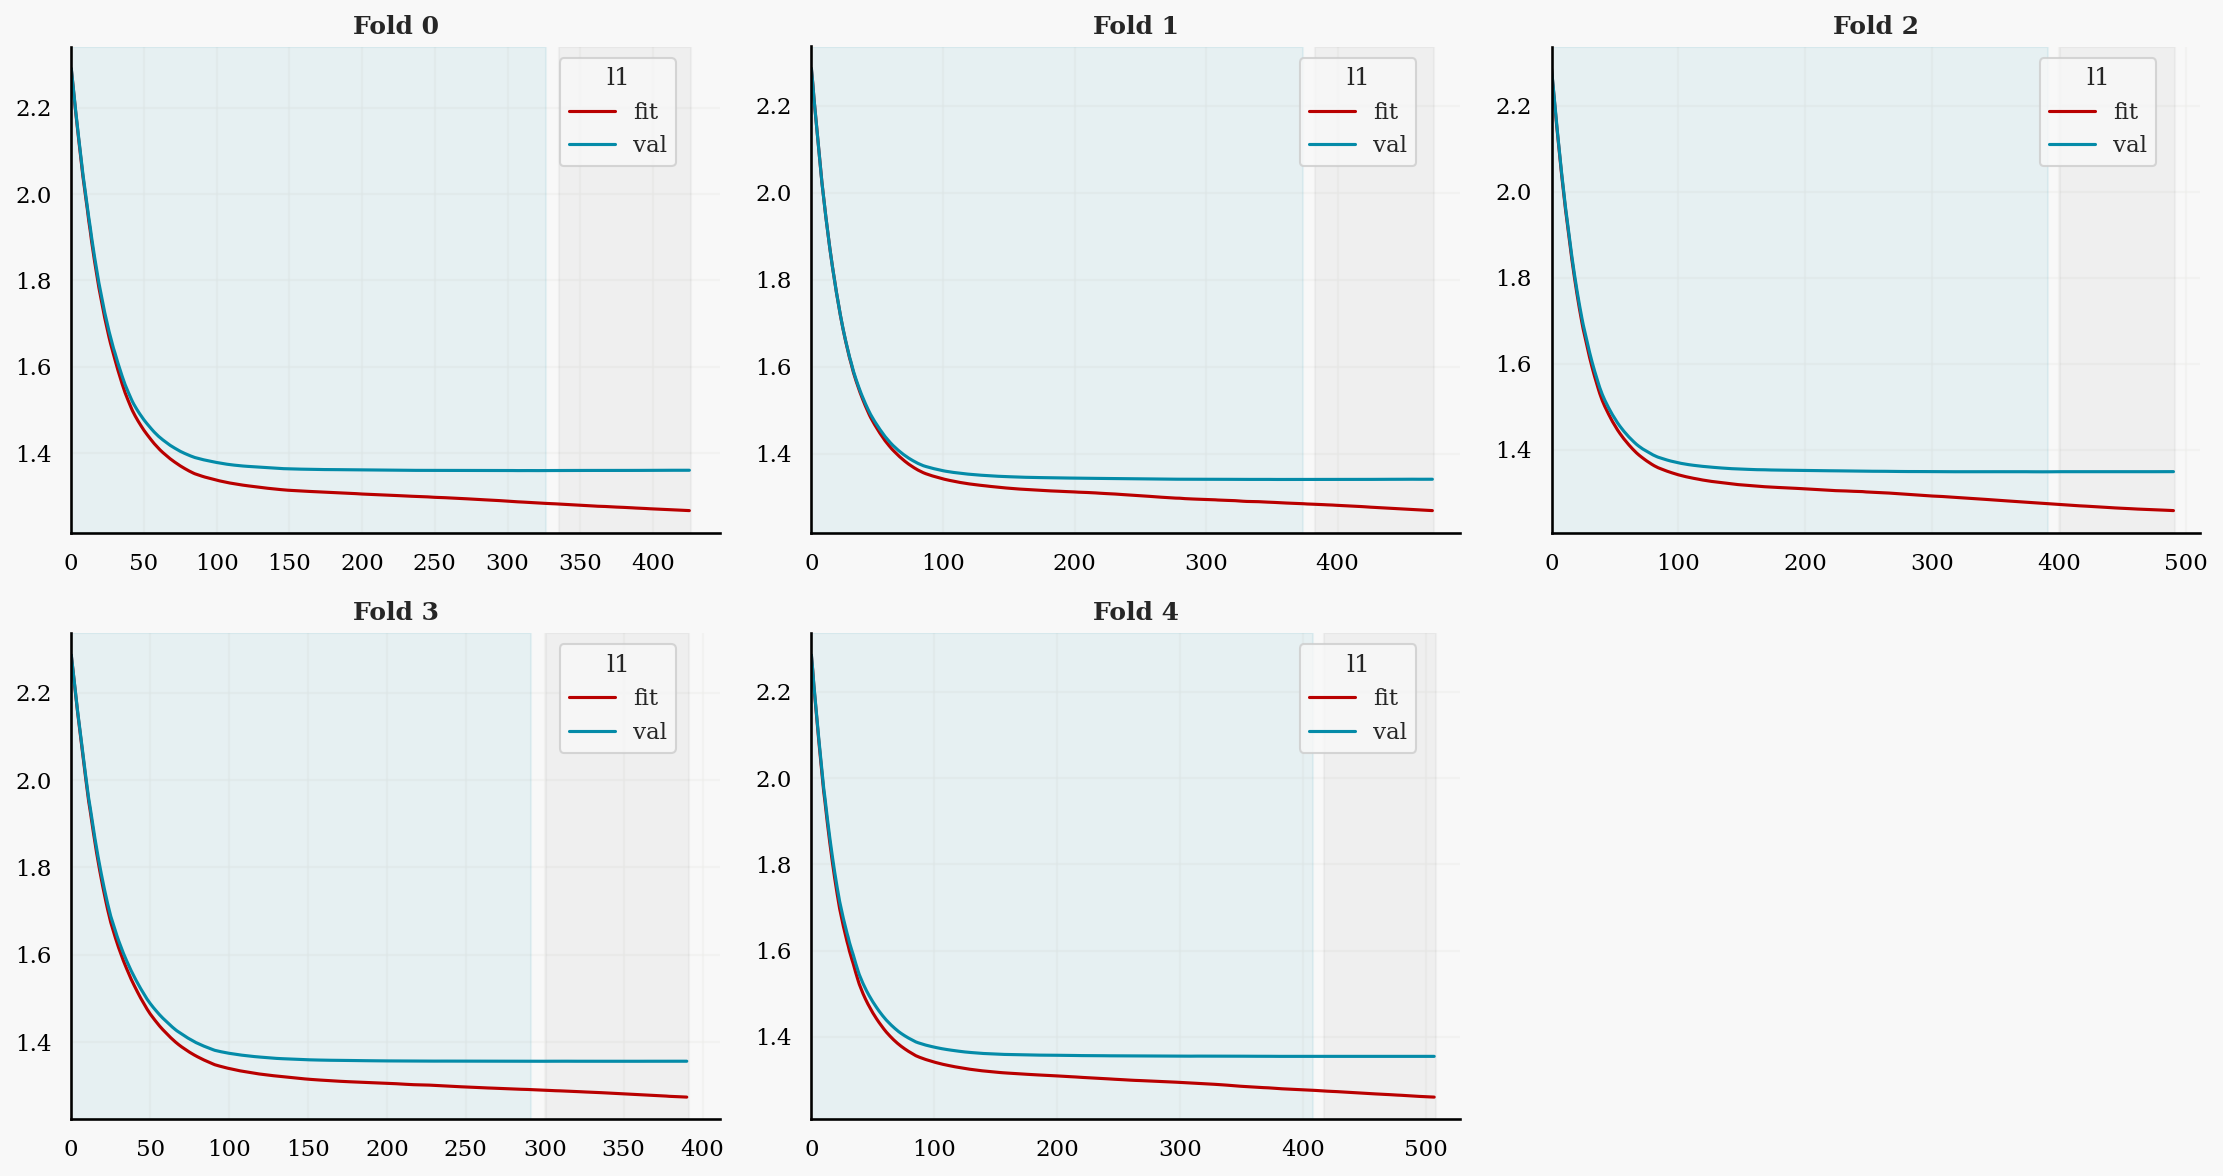

In [40]:
palette = sns.color_palette("tab10")

fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=150)
ax = axes.flatten()
for i, (m, e) in enumerate(zip(models, eval_results_list)): 
    metric_score_folds = pd.DataFrame.from_dict(e).T
    fit_mae = metric_score_folds.loc[:, 'l1'][0]
    val_mae = metric_score_folds.loc[:, 'l1'][1]

    sns.lineplot(fit_mae, color='#B90000', ax=ax[i], label='fit')
    sns.lineplot(val_mae, color='#048BA8', ax=ax[i], label='val')
    ax[i].legend()
    ax[i].spines['top'].set_visible(False);
    ax[i].spines['right'].set_visible(False)
    ax[i].set_title(f'Fold {i}', fontdict={'fontweight': 'bold'})
    
    color =  ['#048BA8', palette[-3]]
    best_iter = m.best_iteration
    span_range = [[0, best_iter], [best_iter + 10, best_iter + lgb_params['early_stopping_round']]]
    
    for idx, sub_title in enumerate([f'Best\nIteration: {best_iter}', f'Early\n Stopping: {lgb_params["early_stopping_round"]}']):
        ax[i].annotate(sub_title,
                    xy=(sum(span_range[idx])/2 , 2000), 
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax[i].axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)
        
    ax[i].set_xlim(0, best_iter + 20 + lgb_params["early_stopping_round"])
    ax[i].legend(bbox_to_anchor=(0.95, 1), loc='upper right', title=lgb_params["metric"])

ax[-1].axis('off')

plt.tight_layout();

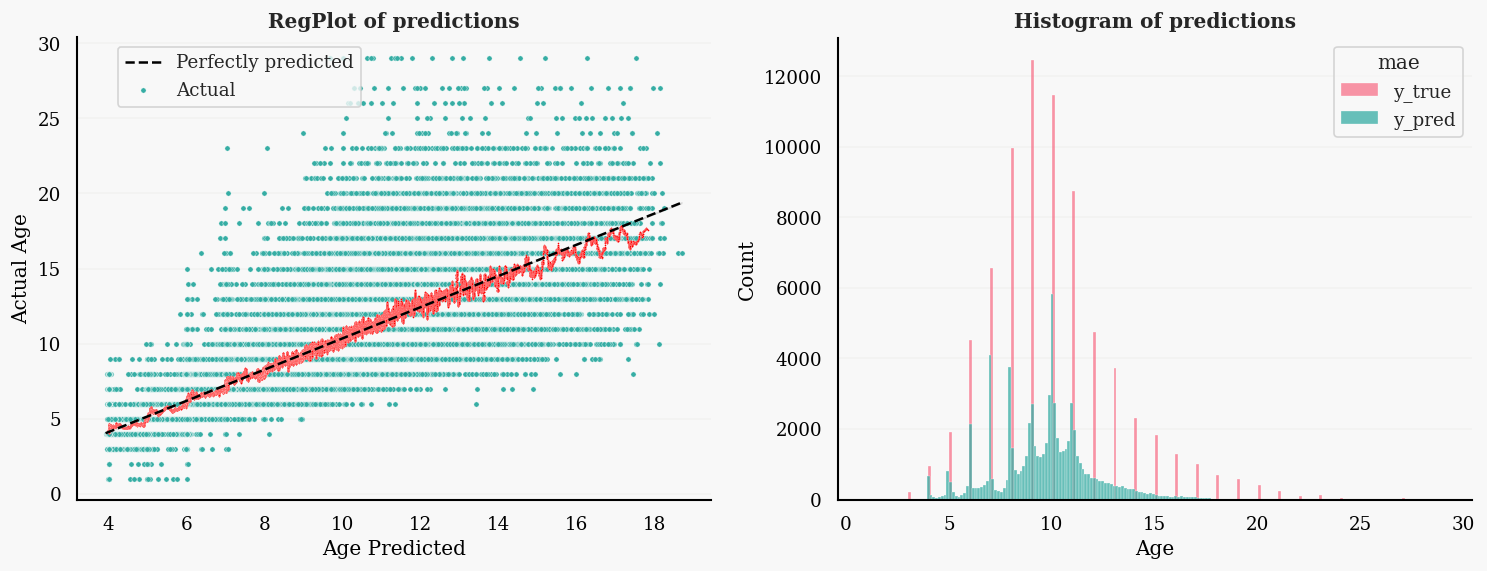

In [41]:
sort_idxs = np.argsort(oof)
oof_sorted = oof[sort_idxs]
y_true_sorted = df['Age'].iloc[sort_idxs]
y_true_sorted = pd.Series(y_true_sorted.values, index=oof_sorted)
y_roll_mean = y_true_sorted.rolling(80, center=True).mean()

palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
ax = ax.flatten()

sns.regplot(data=oof_df, x='Age_pred', y='Age', color=palette[1], scatter=False,
            line_kws={"color": "black", "linestyle": "--", "lw": 1.5}, ax=ax[0], label='Perfectly predicted')

sns.scatterplot(data=oof_df, x='Age_pred', y='Age', s=10, color=palette[1], ax=ax[0], label='Actual')
sns.scatterplot(x=y_roll_mean.index, y=y_roll_mean, color='red', s=1, ax=ax[0])

ax[0].legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax[0].set(xlabel='Age Predicted', ylabel='Actual Age')

sns.histplot(oof_df['Age'], color=palette[0], label='y_true', ax=ax[1])
sns.histplot(oof_df['Age_pred'], color=palette[1], label='y_pred', ax=ax[1])
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right', title='mae')
for i, _ in enumerate(ax):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].xaxis.grid(False)
    ax[i].yaxis.grid(True)

ax[0].set_title(f'RegPlot of predictions', fontdict={'fontweight': 'bold'})
ax[1].set_title(f'Histogram of predictions', fontdict={'fontweight': 'bold'});

In [42]:
predictions = model.predict(test)
predictions_rounded = np.round(predictions).astype(int)
submission['Age'] = predictions_rounded

In [43]:
submission

id  Age
0       74051    7
1       74052    8
2       74053   10
3       74054    9
4       74055    7
...       ...  ...
49363  123414    9
49364  123415    8
49365  123416   13
49366  123417   10
49367  123418   11

[49368 rows x 2 columns]

In [44]:
submission.to_csv(r"submission.csv", index=False)